# ExDEx Exercise 2 Code

**Group 7:** Dominik J. Gorickic, Brandon J. Nader, Manuel Petschinger, Michael Wolkerstorfer

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [21]:
path_cwd = os.getcwd()

Do countries with a higher share of organic agricultural area demonstrate higher or lower overall agricultural output or value-added per unit of land?

In [22]:
# Read the datasets
df_organic = pd.read_csv('EUROSTAT/Agricultural_Holdings_With_Organic_Area.tsv', sep='\t')
df_output = pd.read_csv('EUROSTAT/Output_of_the_agricultural_industry_basic_and_producer_prices_.tsv', sep='\t')
df_land_use = pd.read_csv('EUROSTAT/Farm_Land_Use.tsv', sep='\t')


In [23]:

# 1. Clean the land use data

# Rename the first column
df_land_use = df_land_use.rename(columns={df_land_use.columns[0]: 'metadata'})

# Split the metadata column
metadata_split = df_land_use['metadata'].str.split(',', expand=True)
df_land_use['freq'] = metadata_split[0]
df_land_use['so_eur'] = metadata_split[1]
df_land_use['crops'] = metadata_split[2]
df_land_use['unit'] = metadata_split[3]
df_land_use['geo_time'] = metadata_split[4]

# Split geo and time
df_land_use['geo'] = df_land_use['geo_time'].str.split('\\').str[0]
df_land_use['time_period'] = df_land_use['geo_time'].str.split('\\').str[1] if '\\' in df_land_use['geo_time'].iloc[0] else 'TIME_PERIOD'

# Clean year column names 
df_land_use.columns = [col.strip() if isinstance(col, str) else col for col in df_land_use.columns]

# Get year columns
year_cols = [col for col in df_land_use.columns if col.isdigit()]

# Filter for organic area and total UAA
organic_area = df_land_use[df_land_use['crops'] == 'UAAXK0000_ORG'].copy()
total_uua = df_land_use[df_land_use['crops'] == 'UAA'].copy()

# Melt organic area data
organic_melted = organic_area.melt(id_vars=['geo', 'crops'], 
                                  value_vars=year_cols,
                                  var_name='year', 
                                  value_name='organic_area_ha')
organic_melted['year'] = organic_melted['year'].astype(int)

# Melt total UAA data
total_uua_melted = total_uua.melt(id_vars=['geo', 'crops'],
                                 value_vars=year_cols,
                                 var_name='year',
                                 value_name='total_uua_ha')
total_uua_melted['year'] = total_uua_melted['year'].astype(int)

# Clean numeric values
def clean_numeric(value):
    if isinstance(value, str):
        value = value.strip()
        if value in [':', '', 'nan', 'NaN']:
            return np.nan
        # Remove flags 
        value = value.replace('i', '').replace('u', '').replace('e', '').replace('@', '').replace('C', '')
        try:
            return float(value)
        except:
            return np.nan
    return value

organic_melted['organic_area_ha'] = organic_melted['organic_area_ha'].apply(clean_numeric)
total_uua_melted['total_uua_ha'] = total_uua_melted['total_uua_ha'].apply(clean_numeric)

# Merge and calculate organic share
organic_data = pd.merge(organic_melted[['geo', 'year', 'organic_area_ha']],
                       total_uua_melted[['geo', 'year', 'total_uua_ha']],
                       on=['geo', 'year'], how='inner')
organic_data['organic_share'] = organic_data['organic_area_ha'] / organic_data['total_uua_ha']


In [24]:

# 2. Clean output data

df_output = df_output.rename(columns={df_output.columns[0]: 'metadata'})
metadata_split_output = df_output['metadata'].str.split(',', expand=True)
df_output['freq'] = metadata_split_output[0]
df_output['itm_newa'] = metadata_split_output[1]
df_output['indic_ag'] = metadata_split_output[2]
df_output['unit'] = metadata_split_output[3]
df_output['geo_time'] = metadata_split_output[4]

df_output['geo'] = df_output['geo_time'].str.split('\\').str[0]
df_output.columns = [col.strip() if isinstance(col, str) else col for col in df_output.columns]

# Get year columns for output
output_year_cols = [col for col in df_output.columns if col.isdigit()]

# Filter for basic prices 
output_data = df_output[df_output['indic_ag'] == 'PROD_BP'].copy()

# Melt output data
output_melted = output_data.melt(id_vars=['geo', 'indic_ag'],
                                value_vars=output_year_cols,
                                var_name='year',
                                value_name='output_mio_eur')
output_melted['year'] = output_melted['year'].astype(int)
output_melted['output_mio_eur'] = output_melted['output_mio_eur'].apply(clean_numeric)
output_melted['output_eur'] = output_melted['output_mio_eur'] * 1000000  # Convert to EUR


In [25]:

# 3. Merge all data

# Merge output with total UAA 
output_with_area = pd.merge(output_melted[['geo', 'year', 'output_eur']],
                           total_uua_melted[['geo', 'year', 'total_uua_ha']],
                           on=['geo', 'year'], how='inner')

# Calculate output per hectare
output_with_area['output_per_ha'] = output_with_area['output_eur'] / output_with_area['total_uua_ha']

# Merge with organic share
final_data = pd.merge(organic_data[['geo', 'year', 'organic_share']],
                      output_with_area[['geo', 'year', 'output_per_ha']],
                      on=['geo', 'year'], how='inner')

# Remove missing values
final_data = final_data.dropna()

print(f"Total observations: {len(final_data)}")
print(f"Countries: {final_data['geo'].nunique()}")
print(f"Years: {final_data['year'].min()} to {final_data['year'].max()}")


Total observations: 110
Countries: 32
Years: 2013 to 2023



Overall correlation: -0.173


C:\Users\domin\AppData\Local\Temp\ipykernel_10888\1282478628.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_data['organic_group'] = pd.qcut(latest_data['organic_share'], q=4,
C:\Users\domin\AppData\Local\Temp\ipykernel_10888\1282478628.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels)


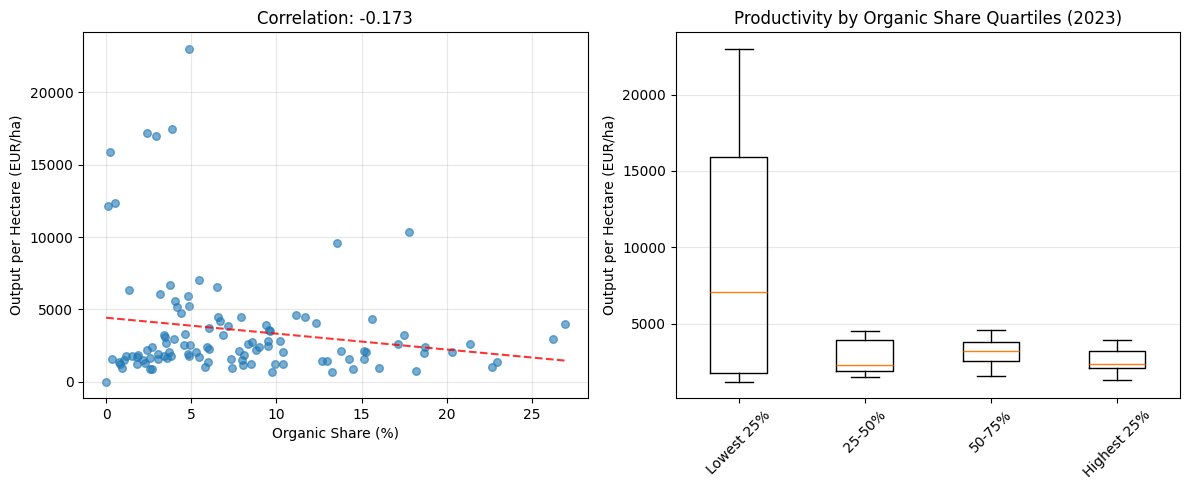

In [26]:

# 4. Analysis

# Correlation
correlation = final_data['organic_share'].corr(final_data['output_per_ha'])
print(f"\nOverall correlation: {correlation:.3f}")


# Visualization
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(final_data['organic_share'] * 100, final_data['output_per_ha'], 
           alpha=0.6, s=30)
plt.xlabel('Organic Share (%)')
plt.ylabel('Output per Hectare (EUR/ha)')
plt.title(f'Correlation: {correlation:.3f}')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(final_data['organic_share'] * 100, final_data['output_per_ha'], 1)
p = np.poly1d(z)
x_range = np.linspace(0, final_data['organic_share'].max() * 100, 100)
plt.plot(x_range, p(x_range), "r--", alpha=0.8)

# Box plot comparison
plt.subplot(1, 2, 2)
latest_year = final_data['year'].max()
latest_data = final_data[final_data['year'] == latest_year]

# Create groups
latest_data['organic_group'] = pd.qcut(latest_data['organic_share'], q=4, 
                                      labels=['Lowest 25%', '25-50%', '50-75%', 'Highest 25%'])

# Data for box plot
box_data = []
labels = []
for group in ['Lowest 25%', '25-50%', '50-75%', 'Highest 25%']:
    group_data = latest_data[latest_data['organic_group'] == group]['output_per_ha']
    if len(group_data) > 0:
        box_data.append(group_data)
        labels.append(group)

plt.boxplot(box_data, labels=labels)
plt.ylabel('Output per Hectare (EUR/ha)')
plt.title(f'Productivity by Organic Share Quartiles ({latest_year})')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [27]:

# 5. Results

# Top and bottom performers
print(f"\nTop 5 by organic share:")
top5 = latest_data.nlargest(5, 'organic_share')
for i, (_, row) in enumerate(top5.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['organic_share']*100:.1f}% organic, {row['output_per_ha']:.0f} EUR/ha")

print(f"\nBottom 5 by organic share:")
bottom5 = latest_data.nsmallest(5, 'organic_share')
for i, (_, row) in enumerate(bottom5.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['organic_share']*100:.1f}% organic, {row['output_per_ha']:.0f} EUR/ha")

# Summary statistics
print(f"\nSummary Statistics ({latest_year}):")
print(f"Average organic share: {latest_data['organic_share'].mean()*100:.1f}%")
print(f"Median organic share: {latest_data['organic_share'].median()*100:.1f}%")
print(f"Average output per hectare: {latest_data['output_per_ha'].mean():.0f} EUR/ha")
print(f"Median output per hectare: {latest_data['output_per_ha'].median():.0f} EUR/ha")

# Top vs bottom quartile
top_quartile = latest_data[latest_data['organic_group'] == 'Highest 25%']
bottom_quartile = latest_data[latest_data['organic_group'] == 'Lowest 25%']

print(f"\nComparison of highest vs lowest organic quartile:")
print(f"Highest 25% organic: {len(top_quartile)} countries, avg output: {top_quartile['output_per_ha'].mean():.0f} EUR/ha")
print(f"Lowest 25% organic: {len(bottom_quartile)} countries, avg output: {bottom_quartile['output_per_ha'].mean():.0f} EUR/ha")
difference = top_quartile['output_per_ha'].mean() - bottom_quartile['output_per_ha'].mean()
print(f"Difference: {difference:+.0f} EUR/ha ({difference/bottom_quartile['output_per_ha'].mean()*100:+.1f}%)")

# 6. Time trend analysis 
if final_data['year'].nunique() > 1:
    
    # Calculate average organic share and output per year
    yearly_stats = final_data.groupby('year').agg({
        'organic_share': 'mean',
        'output_per_ha': 'mean'
    }).reset_index()
    
    print(f"\nYearly averages:")
    for _, row in yearly_stats.iterrows():
        print(f"{row['year']}: {row['organic_share']*100:.1f}% organic, {row['output_per_ha']:.0f} EUR/ha")
    
    # Calculate changes
    if len(yearly_stats) >= 2:
        first_year = yearly_stats['year'].min()
        last_year = yearly_stats['year'].max()
        
        first_row = yearly_stats[yearly_stats['year'] == first_year].iloc[0]
        last_row = yearly_stats[yearly_stats['year'] == last_year].iloc[0]
        
        organic_change = (last_row['organic_share'] - first_row['organic_share']) / first_row['organic_share'] * 100
        output_change = (last_row['output_per_ha'] - first_row['output_per_ha']) / first_row['output_per_ha'] * 100
        
        print(f"\nChange from {first_year} to {last_year}:")
        print(f"Organic share: {organic_change:+.1f}%")
        print(f"Output per hectare: {output_change:+.1f}%")



Top 5 by organic share:
1. AT: 26.9% organic, 3963 EUR/ha
2. EE: 22.9% organic, 1342 EUR/ha
3. SE: 18.7% organic, 2391 EUR/ha
4. PT: 17.5% organic, 3243 EUR/ha
5. CZ: 15.3% organic, 2092 EUR/ha

Bottom 5 by organic share:
1. MT: 0.2% organic, 15893 EUR/ha
2. BG: 1.8% organic, 1221 EUR/ha
3. NL: 4.9% organic, 22984 EUR/ha
4. RO: 4.9% organic, 1770 EUR/ha
5. CY: 5.5% organic, 7053 EUR/ha

Summary Statistics (2023):
Average organic share: 10.6%
Median organic share: 9.4%
Average output per hectare: 4668 EUR/ha
Median output per hectare: 2843 EUR/ha

Comparison of highest vs lowest organic quartile:
Highest 25% organic: 5 countries, avg output: 2606 EUR/ha
Lowest 25% organic: 5 countries, avg output: 9784 EUR/ha
Difference: -7178 EUR/ha (-73.4%)

Yearly averages:
2013.0: 5.5% organic, 3316 EUR/ha
2016.0: 7.4% organic, 3121 EUR/ha
2020.0: 8.9% organic, 3563 EUR/ha
2023.0: 10.6% organic, 4668 EUR/ha

Change from 2013 to 2023:
Organic share: +91.1%
Output per hectare: +40.8%


Is there a relationship between farm manager training/age and the adoption of organic farming, higher-value production, or better economic results?

In [28]:
# Datasets
df_manager_age = pd.read_csv('EUROSTAT/Agricultural_Holdings_By_Manager_Age.tsv', sep='\t')
df_manager_training = pd.read_csv('EUROSTAT/Agricultural_Holdings_By_Manager_Training.tsv', sep='\t')
df_organic = pd.read_csv('EUROSTAT/Agricultural_Holdings_With_Organic_Area.tsv', sep='\t')
df_output = pd.read_csv('EUROSTAT/Output_of_the_agricultural_industry_basic_and_producer_prices_.tsv', sep='\t')
df_land_use = pd.read_csv('EUROSTAT/Farm_Land_Use.tsv', sep='\t')


In [29]:

# Function to clean numeric values
def clean_numeric(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        value = value.strip()
        if value in [':', '', 'nan', 'NaN', 'NAN']:
            return np.nan
        # Remove flags
        value = value.replace('i', '').replace('u', '').replace('e', '').replace('@', '').replace('C', '')
        try:
            return float(value)
        except:
            return np.nan
    return value

# 1. Process Manager Age Data 

# Rename first column
df_age = df_manager_age.rename(columns={df_manager_age.columns[0]: 'metadata'})

# Split metadata
metadata_split = df_age['metadata'].str.split(',', expand=True)
df_age['freq'] = metadata_split[0]
df_age['so_eur'] = metadata_split[1]
df_age['sex'] = metadata_split[2]
df_age['age'] = metadata_split[3]
df_age['unit'] = metadata_split[4]
df_age['geo_time'] = metadata_split[5]

# Get geo code
df_age['geo'] = df_age['geo_time'].str.split('\\').str[0]

# Clean column names
df_age.columns = [str(col).strip() for col in df_age.columns]

# Get year columns
age_year_cols = [col for col in df_age.columns if col.isdigit()]

# Filter for relevant data: TOTAL sex and TOTAL age and young age groups
df_age_total = df_age[(df_age['sex'] == 'T') & (df_age['age'] == 'TOTAL')].copy()
df_age_young = df_age[(df_age['sex'] == 'T') & (df_age['age'].isin(['Y_LT25', 'Y25-34', 'Y35-39', 'Y40-44']))].copy()

# Melt total holders data
age_total_melted = df_age_total.melt(id_vars=['geo', 'age'], 
                                     value_vars=age_year_cols,
                                     var_name='year', 
                                     value_name='total_holders')
age_total_melted['year'] = age_total_melted['year'].astype(int)
age_total_melted['total_holders'] = age_total_melted['total_holders'].apply(clean_numeric)

# Melt young holders data
age_young_melted = df_age_young.melt(id_vars=['geo', 'age'], 
                                     value_vars=age_year_cols,
                                     var_name='year', 
                                     value_name='young_holders')
age_young_melted['year'] = age_young_melted['year'].astype(int)
age_young_melted['young_holders'] = age_young_melted['young_holders'].apply(clean_numeric)

# Sum all young age groups per country/year
young_summary = age_young_melted.groupby(['geo', 'year'])['young_holders'].sum().reset_index()

# Merge with total holders
age_data = pd.merge(young_summary, 
                    age_total_melted[['geo', 'year', 'total_holders']],
                    on=['geo', 'year'], how='inner')

# Calculate young manager share (under 45)
age_data['young_share'] = age_data['young_holders'] / age_data['total_holders']


In [30]:

# 2.  Organic Data

# Clean organic data
df_org = df_organic.rename(columns={df_organic.columns[0]: 'metadata'})
metadata_split_org = df_org['metadata'].str.split(',', expand=True)
df_org['freq'] = metadata_split_org[0]
df_org['uaarea'] = metadata_split_org[1]
df_org['so_eur'] = metadata_split_org[2]
df_org['farmtype'] = metadata_split_org[3]
df_org['crops'] = metadata_split_org[4]
df_org['unit'] = metadata_split_org[5]
df_org['geo_time'] = metadata_split_org[6]
df_org['geo'] = df_org['geo_time'].str.split('\\').str[0]

# Clean column names
df_org.columns = [str(col).strip() for col in df_org.columns]
org_year_cols = [col for col in df_org.columns if col.isdigit()]

# Filter for organic holdings
org_data = df_org[df_org['crops'] == 'UAAXK0000_ORG'].copy()

# Melt organic data
org_melted = org_data.melt(id_vars=['geo', 'crops'], 
                           value_vars=org_year_cols,
                           var_name='year', 
                           value_name='organic_holdings')
org_melted['year'] = org_melted['year'].astype(int)
org_melted['organic_holdings'] = org_melted['organic_holdings'].apply(clean_numeric)


In [31]:

# 3. Data for Economic Results

# Clean output data
df_out = df_output.rename(columns={df_output.columns[0]: 'metadata'})
metadata_split_out = df_out['metadata'].str.split(',', expand=True)
df_out['freq'] = metadata_split_out[0]
df_out['itm_newa'] = metadata_split_out[1]
df_out['indic_ag'] = metadata_split_out[2]
df_out['unit'] = metadata_split_out[3]
df_out['geo_time'] = metadata_split_out[4]
df_out['geo'] = df_out['geo_time'].str.split('\\').str[0]

# Clean column names
df_out.columns = [str(col).strip() for col in df_out.columns]
out_year_cols = [col for col in df_out.columns if col.isdigit()]

# Get output value (basic prices)
output_data = df_out[df_out['indic_ag'] == 'PROD_BP'].copy()

# Melt output data
output_melted = output_data.melt(id_vars=['geo'], 
                                 value_vars=out_year_cols,
                                 var_name='year', 
                                 value_name='output_mio_eur')
output_melted['year'] = output_melted['year'].astype(int)
output_melted['output_mio_eur'] = output_melted['output_mio_eur'].apply(clean_numeric)
output_melted['output_eur'] = output_melted['output_mio_eur'] * 1000000


In [32]:

# 4. Land Use Data for area

# Clean land use data
df_land = df_land_use.rename(columns={df_land_use.columns[0]: 'metadata'})
metadata_split_land = df_land['metadata'].str.split(',', expand=True)
df_land['freq'] = metadata_split_land[0]
df_land['so_eur'] = metadata_split_land[1]
df_land['crops'] = metadata_split_land[2]
df_land['unit'] = metadata_split_land[3]
df_land['geo_time'] = metadata_split_land[4]
df_land['geo'] = df_land['geo_time'].str.split('\\').str[0]

# Clean column names
df_land.columns = [str(col).strip() for col in df_land.columns]
land_year_cols = [col for col in df_land.columns if col.isdigit()]

# Get total UAA
land_total = df_land[df_land['crops'] == 'UAA'].copy()

# Melt land data
land_melted = land_total.melt(id_vars=['geo'], 
                              value_vars=land_year_cols,
                              var_name='year', 
                              value_name='total_uua_ha')
land_melted['year'] = land_melted['year'].astype(int)
land_melted['total_uua_ha'] = land_melted['total_uua_ha'].apply(clean_numeric)


In [33]:

# 5. Merge All Data

# Start with age data
merged_data = age_data[['geo', 'year', 'young_share']].copy()

# Merge with organic
merged_data = pd.merge(merged_data, 
                       org_melted[['geo', 'year', 'organic_holdings']],
                       on=['geo', 'year'], how='inner')

# Merge with land area
merged_data = pd.merge(merged_data, 
                       land_melted[['geo', 'year', 'total_uua_ha']],
                       on=['geo', 'year'], how='inner')

# Merge with output
merged_data = pd.merge(merged_data, 
                       output_melted[['geo', 'year', 'output_eur']],
                       on=['geo', 'year'], how='inner')

# Calculate derived metrics
# Organic share = organic holdings / total UAA (approximate)
merged_data['organic_share'] = merged_data['organic_holdings'] / merged_data['total_uua_ha']
merged_data['output_per_ha'] = merged_data['output_eur'] / merged_data['total_uua_ha']

# Remove rows with missing data
merged_data = merged_data.dropna()

print(f"\nData ready for analysis!")
print(f"Total observations: {len(merged_data)}")
print(f"Countries: {merged_data['geo'].nunique()}")
print(f"Years: {merged_data['year'].min()} to {merged_data['year'].max()}")

# 6. Analysis

# Get latest year data
latest_year = merged_data['year'].max()
latest_data = merged_data[merged_data['year'] == latest_year].copy()

print(f"\nAnalysis for {latest_year}:")
print(f"Countries: {len(latest_data)}")

# Correlation
corr_organic = latest_data['young_share'].corr(latest_data['organic_share'])
corr_output = latest_data['young_share'].corr(latest_data['output_per_ha'])

print(f"\nCorrelations:")
print(f"Young managers vs Organic share: {corr_organic:.3f}")
print(f"Young managers vs Output per hectare: {corr_output:.3f}")



Data ready for analysis!
Total observations: 110
Countries: 32
Years: 2013 to 2023

Analysis for 2023:
Countries: 19

Correlations:
Young managers vs Organic share: -0.244
Young managers vs Output per hectare: -0.244


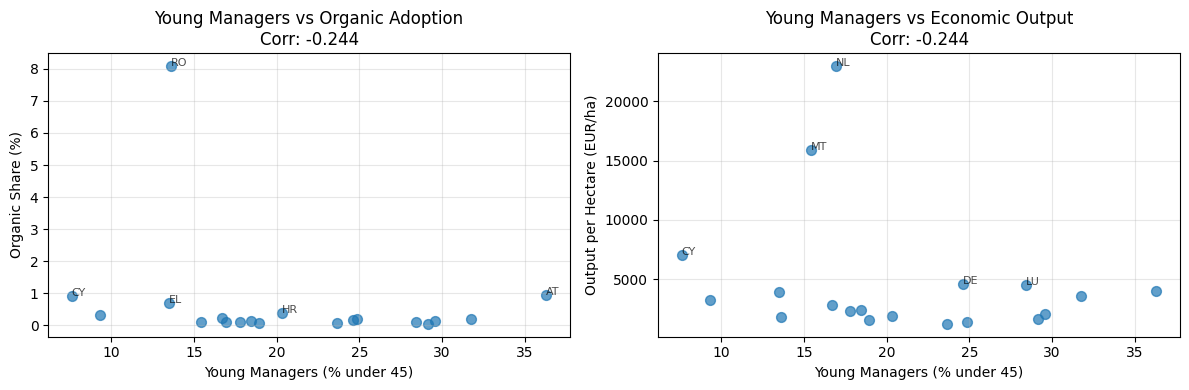

In [34]:

# 7. Visualization
plt.figure(figsize=(12, 4))

# Plot 1: Young managers vs Organic
plt.subplot(1, 2, 1)
plt.scatter(latest_data['young_share'] * 100, 
            latest_data['organic_share'] * 100, 
            alpha=0.7, s=50)
plt.xlabel('Young Managers (% under 45)')
plt.ylabel('Organic Share (%)')
plt.title(f'Young Managers vs Organic Adoption\nCorr: {corr_organic:.3f}')
plt.grid(True, alpha=0.3)

top_organic = latest_data.nlargest(5, 'organic_share')
for _, row in top_organic.iterrows():
    plt.text(row['young_share'] * 100, row['organic_share'] * 100, 
             row['geo'], fontsize=8, alpha=0.7)

# Plot 2: Young managers vs Output
plt.subplot(1, 2, 2)
plt.scatter(latest_data['young_share'] * 100, 
            latest_data['output_per_ha'], 
            alpha=0.7, s=50)
plt.xlabel('Young Managers (% under 45)')
plt.ylabel('Output per Hectare (EUR/ha)')
plt.title(f'Young Managers vs Economic Output\nCorr: {corr_output:.3f}')
plt.grid(True, alpha=0.3)

top_output = latest_data.nlargest(5, 'output_per_ha')
for _, row in top_output.iterrows():
    plt.text(row['young_share'] * 100, row['output_per_ha'], 
             row['geo'], fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# 8. Analysis

# Compare top and bottom quartiles by young manager share
latest_data['young_quartile'] = pd.qcut(latest_data['young_share'], q=2, 
                                       labels=['Bottom 50%', 'Top 50%'])

young_stats = latest_data.groupby('young_quartile').agg({
    'organic_share': 'mean',
    'output_per_ha': 'mean',
    'geo': 'count'
}).round(4)

print(f"\nAverage values:")
print(f"{'':<15} {'Countries':<10} {'Organic %':<12} {'Output EUR/ha':<15}")
print("-" * 50)
for quartile in ['Bottom 50%', 'Top 50%']:
    stats = young_stats.loc[quartile]
    print(f"{quartile:<15} {int(stats['geo']):<10} {stats['organic_share']*100:.1f}%{'':<4} {stats['output_per_ha']:.0f}")



Average values:
                Countries  Organic %    Output EUR/ha  
--------------------------------------------------
Bottom 50%      10         1.1%     6391
Top 50%         9          0.2%     2755


C:\Users\domin\AppData\Local\Temp\ipykernel_10888\3791994956.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  young_stats = latest_data.groupby('young_quartile').agg({


In [36]:

# 9. Examples
print("\n" + "="*70)
print("COUNTRY EXAMPLES")

print(f"\nTop 5 countries by young manager share:")
top_young = latest_data.nlargest(5, 'young_share')
for i, (_, row) in enumerate(top_young.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['young_share']*100:.1f}% young, "
          f"{row['organic_share']*100:.1f}% organic, "
          f"{row['output_per_ha']:.0f} EUR/ha")

print(f"\nBottom 5 countries by young manager share:")
bottom_young = latest_data.nsmallest(5, 'young_share')
for i, (_, row) in enumerate(bottom_young.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['young_share']*100:.1f}% young, "
          f"{row['organic_share']*100:.1f}% organic, "
          f"{row['output_per_ha']:.0f} EUR/ha")

# 10. Summary

print(f"\n3. FINDINGS:")
print(f"   Countries with most young managers have {young_stats.loc['Top 50%', 'organic_share']*100:.1f}% organic")
print(f"   Countries with fewest young managers have {young_stats.loc['Bottom 50%', 'organic_share']*100:.1f}% organic")

organic_diff = (young_stats.loc['Top 50%', 'organic_share'] - young_stats.loc['Bottom 50%', 'organic_share']) / young_stats.loc['Bottom 50%', 'organic_share'] * 100
output_diff = (young_stats.loc['Top 50%', 'output_per_ha'] - young_stats.loc['Bottom 50%', 'output_per_ha']) / young_stats.loc['Bottom 50%', 'output_per_ha'] * 100

print(f"   Difference: {organic_diff:+.1f}% in organic adoption")
print(f"   Difference: {output_diff:+.1f}% in output per hectare")


COUNTRY EXAMPLES

Top 5 countries by young manager share:
1. AT: 36.3% young, 0.9% organic, 3963 EUR/ha
2. FR: 31.7% young, 0.2% organic, 3565 EUR/ha
3. CZ: 29.5% young, 0.1% organic, 2092 EUR/ha
4. SK: 29.2% young, 0.1% organic, 1612 EUR/ha
5. LU: 28.4% young, 0.1% organic, 4509 EUR/ha

Bottom 5 countries by young manager share:
1. CY: 7.6% young, 0.9% organic, 7053 EUR/ha
2. PT: 9.3% young, 0.3% organic, 3243 EUR/ha
3. EL: 13.5% young, 0.7% organic, 3922 EUR/ha
4. RO: 13.6% young, 8.1% organic, 1770 EUR/ha
5. MT: 15.4% young, 0.1% organic, 15893 EUR/ha

3. FINDINGS:
   Countries with most young managers have 0.2% organic
   Countries with fewest young managers have 1.1% organic
   Difference: -76.9% in organic adoption
   Difference: -56.9% in output per hectare


## Crop Yields vs. Climatic Anomalies

To what extent can deviations in European crop yields (2000–2024) be explained by regional climatic
anomalies (temperature and precipitation)?

- Do Southern European countries (e.g., Spain, Italy) show a stronger negative correlation between rising summer temperatures and crop yields compared to Northern European countries (e.g., Sweden, Germany)?

- Is the yield volatility (year-to-year variation) increasing more for rain-fed crops (e.g., wheat) than for irrigated/hardier crops (e.g., olives/grapes)?

- How well can future trends be predicted?

### Copernicus Climate Change Service (C3S) Data Import

First, we use the Climate Data Store (CDS) API to load data temperature and precipitation flux data:

**1. temp_max (Daily Maximum Air Temperature):**

- Scientific Definition: The highest temperature recorded at 2 meters height above the land surface within the 24-hour period.

- Unit: The raw data is in Kelvin (K).

- Why it matters for our analysis: This is the "Heat Stress" indicator. Agriculture is more sensitive to extremes than averages. Even if the average temperature is normal, a single week where temp_max exceeds 30°C or 35°C (depending on the crop) can sterilize pollen or halt grain filling, destroying the harvest.

**2. precip (Precipitation Flux):**

- Scientific Definition: The total volume of water (liquid rain or frozen snow) that reaches the ground per unit area over the 24-hour period.

- Unit: Millimeters (mm) per day, which is equivalent to Liters per square meter ($L/m^2$).

- Why it matters for our analysis: This is your "Water Availability" indicator. You will use this to identify:

    - Droughts: Extended periods during the growing season (April–July) where the cumulative precip is significantly below the 20-year average.
    
    - Floods: Sudden, extreme spikes in precip that can wash away seeds or rot roots.

To run the cell below, we have to create an account on https://cds.climate.copernicus.eu/how-to-api and follow the instructions on the cite to save the API credentials on our local machine.

In [ ]:
import cdsapi
import os

"""
# -- Define the Europe bounding box [North, West, South, East]
EUROPE_AREA = [72, -25, 34, 45]

dataset = "sis-agrometeorological-indicators"
client = cdsapi.Client()

# -- Automate month and day lists
months = [f"{i:02d}" for i in range(1, 13)]
days = [f"{i:02d}" for i in range(1, 32)]

# -- Define the variables we want to download (separated because they require different parameters)
data_configs = [
    {
        "name": "temp_max",  # for filename
        "params": {
            "variable": "2m_temperature",
            "statistic": "24_hour_maximum"
        }
    },
    {
        "name": "precip",    # for filename
        "params": {
            "variable": "precipitation_flux"
            # Note: 'statistic' is removed here as it is not valid for flux
        }
    }
]

# -- Loop through years and variables
for year in range(2000, 2025):
    year_str = str(year)
    
    for config in data_configs:
        # Construct a unique filename for this variable/year combination
        output_file = f"agera5_europe_{config['name']}_{year_str}.zip"
        
        # Skip if already downloaded
        if os.path.exists(output_file):
            print(f"Skipping {output_file}, already exists.")
            continue
        
        print(f"Requesting {config['name']} for {year_str}...")
        
        # Base request with common parameters
        request = {
            "year": year_str,
            "month": months,
            "day": days,
            "version": "1_1",
            "format": "zip",
            "area": EUROPE_AREA
        }
        
        # Update request with specific variable parameters (variable name + statistic)
        request.update(config['params'])

        try:
            client.retrieve(dataset, request, output_file)
            print(f"Download complete: {output_file}")
        except Exception as e:
            print(f"Failed to download {output_file}: {e}")
"""

Since we downloaded zip-files that include lots of .nc files, we need to further process the data. In the next step, we extract only the relevant data for the EU-27 countries. Our project has a strong focus on agriculture which is why we select a well-known agricultural region for each country. The countries and their specific coordinates are listed below. Our goal is to output a csv-file that contains the temperature and precipitation flux data for each day from 2000 to 2024 and for each EU-27 country.

In [2]:
import zipfile
import os
import glob
import xarray as xr
import pandas as pd
import shutil

ZIP_FOLDER = "./"            
TEMP_EXTRACT_FOLDER = "./temp_nc_files"
OUTPUT_CSV = "./C3S/europe_climate_by_location_2000_2024.csv"

# -- List of EU-27 Agricultural Regions (approximate centroids)
LOCATIONS = [
    {'name': 'Austria_Marchfeld',       'lat': 48.20, 'lon': 16.70}, # Major crop area
    {'name': 'Belgium_Hesbaye',         'lat': 50.60, 'lon': 5.20},  # Arable farming
    {'name': 'Bulgaria_Thrace',         'lat': 42.15, 'lon': 24.75}, # Thracian Plain
    {'name': 'Croatia_Slavonia',        'lat': 45.55, 'lon': 18.69}, # Major breadbasket
    {'name': 'Cyprus_Messaoria',        'lat': 35.15, 'lon': 33.35}, # Central plain
    {'name': 'Czechia_Moravia',         'lat': 49.20, 'lon': 16.60}, # Fertile lowlands
    {'name': 'Denmark_Jutland',         'lat': 56.15, 'lon': 9.50},  # Intensive agriculture
    {'name': 'Estonia_Central',         'lat': 58.80, 'lon': 25.60},
    {'name': 'Finland_Varsinais',       'lat': 60.45, 'lon': 23.10}, # Southwest farmlands
    {'name': 'France_CentreValLoire',   'lat': 47.90, 'lon': 1.90},  # The "breadbasket" of France
    {'name': 'Germany_LowerSaxony',     'lat': 52.37, 'lon': 9.73},  # Major arable region
    {'name': 'Greece_Thessaly',         'lat': 39.60, 'lon': 22.40}, # Major agricultural plain
    {'name': 'Hungary_GreatPlain',      'lat': 47.18, 'lon': 20.19}, # Alföld region
    {'name': 'Ireland_Munster',         'lat': 52.25, 'lon': -8.65}, # Dairy/Grazing
    {'name': 'Italy_EmiliaRomagna',     'lat': 44.50, 'lon': 11.35}, # Po Valley (intensive)
    {'name': 'Latvia_Zemgale',          'lat': 56.65, 'lon': 23.70}, # "Breadbasket" of Latvia
    {'name': 'Lithuania_Central',       'lat': 55.17, 'lon': 23.88},
    {'name': 'Luxembourg_Gutland',      'lat': 49.75, 'lon': 6.10},
    {'name': 'Malta_Rural',             'lat': 35.90, 'lon': 14.40},
    {'name': 'Netherlands_Flevoland',   'lat': 52.50, 'lon': 5.50},  # Reclaimed agricultural land
    {'name': 'Poland_Wielkopolska',     'lat': 52.40, 'lon': 16.90}, # Intensive farming
    {'name': 'Portugal_Alentejo',       'lat': 38.00, 'lon': -7.80}, # Major crop region
    {'name': 'Romania_Baragan',         'lat': 44.90, 'lon': 27.00}, # Baragan Plain (cereals)
    {'name': 'Slovakia_Danubian',       'lat': 48.00, 'lon': 17.60}, # Fertile lowlands
    {'name': 'Slovenia_Drava',          'lat': 46.55, 'lon': 15.65},
    {'name': 'Spain_CastillaLeon',      'lat': 41.65, 'lon': -4.72}, # Major cereal plateau
    {'name': 'Sweden_Skane',            'lat': 55.80, 'lon': 13.50}, # Most fertile region
]

VAR_CONFIG = {
    "temp_max": "Temperature_Air_2m_Max_24h", 
    "precip": "Precipitation_Flux"            
}

final_results = []

os.makedirs(TEMP_EXTRACT_FOLDER, exist_ok=True)

# -- Loop through years
for year in range(2000, 2025):
    print(f"--- Processing Year: {year} ---")
    
    zip_files = glob.glob(os.path.join(ZIP_FOLDER, f"*_{year}.zip"))
    if not zip_files:
        continue

    # Extract
    for zf in zip_files:
        with zipfile.ZipFile(zf, 'r') as zip_ref:
            zip_ref.extractall(TEMP_EXTRACT_FOLDER)

    nc_files = glob.glob(os.path.join(TEMP_EXTRACT_FOLDER, "*.nc"))
    
    print(f"  Extracting points from {len(nc_files)} files...")

    # -- Process sequentially
    for f_path in sorted(nc_files):
        try:
            with xr.open_dataset(f_path, engine='netcdf4') as ds:
                time_val = ds.time.values[0]

                # Loop through our defined locations
                for loc in LOCATIONS:
                    # Create base record
                    record = {
                        'time': time_val,
                        'year': year,
                        'location_name': loc['name'],
                        'lat': loc['lat'],
                        'lon': loc['lon']
                    }

                    # Extract data for this specific point (nearest neighbor with .sel)
                    point_data = ds.sel(lat=loc['lat'], lon=loc['lon'], method='nearest')
                    
                    for var_key, var_name_in_nc in VAR_CONFIG.items():
                        if var_name_in_nc in ds:
                            val = point_data[var_name_in_nc].item()
                            record[var_key] = val
                    
                    final_results.append(record)
                    
        except Exception as e:
            print(f"    Error reading file: {e}")

    # Cleanup temp files for this year
    for f in nc_files:
        os.remove(f)

# -- Save final csv
if final_results:
    final_df = pd.concat([pd.DataFrame([r]) for r in final_results], ignore_index=True)
    
    # Merge temp and precip for same location/time and group by time + location
    final_df = final_df.groupby(['time', 'year', 'location_name', 'lat', 'lon'], as_index=False).first()
    
    final_df.to_csv(OUTPUT_CSV, index=False)
    print(f"Success! Saved {len(final_df)} rows to {OUTPUT_CSV}")
    print(final_df.head())

shutil.rmtree(TEMP_EXTRACT_FOLDER)

--- Processing Year: 2000 ---
--- Processing Year: 2001 ---
--- Processing Year: 2002 ---
--- Processing Year: 2003 ---
--- Processing Year: 2004 ---
--- Processing Year: 2005 ---
--- Processing Year: 2006 ---
--- Processing Year: 2007 ---
--- Processing Year: 2008 ---
--- Processing Year: 2009 ---
--- Processing Year: 2010 ---
--- Processing Year: 2011 ---
--- Processing Year: 2012 ---
--- Processing Year: 2013 ---
--- Processing Year: 2014 ---
--- Processing Year: 2015 ---
--- Processing Year: 2016 ---
--- Processing Year: 2017 ---
--- Processing Year: 2018 ---
--- Processing Year: 2019 ---
--- Processing Year: 2020 ---
--- Processing Year: 2021 ---
--- Processing Year: 2022 ---
--- Processing Year: 2023 ---
--- Processing Year: 2024 ---


### Data Preprocessing

First, we preprocess the agriculture data from Eurostat which shows the Crop production in EU standard humidity: `estat_apro_cpsh1.tsv`

In [3]:
# Import the data
df = pd.read_csv('EUROSTAT/estat_apro_cpsh1.tsv', sep='\t')

# Cleaning the header: first column name looks like "freq,crops,strucpro,geo\TIME_PERIOD"
mixed_col_name = df.columns[0]

# Extract separate column names from the header string
new_columns = mixed_col_name.split('\\')[0].split(',')

# Split the values "A,ARA,MA,AL" into 4 separate columns
df[new_columns] = df[mixed_col_name].str.split(',', expand=True)

# Drop the original messy column
df = df.drop(columns=[mixed_col_name])

# Reshape to long format
df_long = df.melt(
    id_vars=new_columns, # Keep these as identifiers
    var_name='year',     # Create a new column called 'year'
    value_name='value'   # Create a new column for the numbers
)

# Clean the Year column: remove extra whitespace and convert to integer
df_long['year'] = df_long['year'].str.strip()

# Filter out purely non-numeric year columns if any exist
df_long = df_long[df_long['year'].str.isnumeric()]
df_long['year'] = df_long['year'].astype(int)

# Eurostat uses ":" for missing values -> 'coerce' turns ":" and "d" into NaN
df_long['value'] = pd.to_numeric(df_long['value'], errors='coerce')

# Reorder columns
crop_df = df_long[new_columns + ['year', 'value']]

crop_df

,freq,crops,strucpro,geo,year,value
0,A,ARA,MA,AL,2000,519.3
1,A,ARA,MA,AT,2000,1381.1
2,A,ARA,MA,BA,2000,NaN
3,A,ARA,MA,BE,2000,867.0
4,A,ARA,MA,BG,2000,3467.5
...,...,...,...,...,...,...
510063,A,W1900,PR_HU_EU,SI,2025,NaN
510064,A,W1900,PR_HU_EU,SK,2025,NaN
510065,A,W1900,PR_HU_EU,TR,2025,NaN
510066,A,W1900,PR_HU_EU,UK,2025,NaN


In the next step, we import and process the previously loaded climate data from C3S.

In [4]:
climate_df = pd.read_csv('C3S/europe_climate_by_location_2000_2024.csv')

# Convert temperature from Kelvin to Celsius
climate_df['temp_max'] = climate_df['temp_max'] - 273.15

climate_df

,time,year,location_name,lat,lon,precip,temp_max
0,2000-01-01,2000,Austria_Marchfeld,48.20,16.70,2.13,-0.513434
1,2000-01-01,2000,Belgium_Hesbaye,50.60,5.20,0.97,6.815729
2,2000-01-01,2000,Bulgaria_Thrace,42.15,24.75,1.77,0.744379
3,2000-01-01,2000,Croatia_Slavonia,45.55,18.69,0.04,1.260095
4,2000-01-01,2000,Cyprus_Messaoria,35.15,33.35,0.00,20.880273
...,...,...,...,...,...,...,...
246559,2024-12-31,2024,Romania_Baragan,44.90,27.00,0.00,7.191949
246560,2024-12-31,2024,Slovakia_Danubian,48.00,17.60,0.28,-0.372809
246561,2024-12-31,2024,Slovenia_Drava,46.55,15.65,0.00,4.676141
246562,2024-12-31,2024,Spain_CastillaLeon,41.65,-4.72,0.08,3.682397


Now, since we have both datasets, we can merge them.

In [5]:
# Map the AgERA5 locations to Eurostat country codes
loc_to_geo = {
    'Spain_CastillaLeon': 'ES',
    'Italy_EmiliaRomagna': 'IT',
    'Greece_Thessaly': 'EL', # Eurostat uses EL for Greece
    'Portugal_Alentejo': 'PT',
    'Sweden_Skane': 'SE',
    'Germany_LowerSaxony': 'DE',
    'Finland_Varsinais': 'FI',
    'Denmark_Jutland': 'DK'
}

# Define your groups
groups = {
    'South': ['ES', 'IT', 'EL', 'PT'],
    'North': ['SE', 'DE', 'FI', 'DK']
}


## PREPARE CLIMATE DATA (Aggregating Daily -> Annual)
# Convert time to datetime if it isn't already
climate_df['time'] = pd.to_datetime(climate_df['time'])

# Filter for Summer Months (June, July, August)
summer_climate = climate_df[climate_df['time'].dt.month.isin([6, 7, 8])].copy()

# Calculate Average Summer Max Temp per Year & Location
climate_annual = summer_climate.groupby(['year', 'location_name'])['temp_max'].mean().reset_index()
climate_annual['summer_temp_c'] = climate_annual['temp_max']
climate_annual['geo'] = climate_annual['location_name'].map(loc_to_geo)

# Drop locations that didn't match our specific list
climate_annual = climate_annual.dropna(subset=['geo'])


## PREPARE CROP DATA
# Filter for Common Wheat (C1100) and Yield (YI_HU_EU)
wheat_yield = crop_df[
    (crop_df['crops'] == 'C1100') & 
    (crop_df['strucpro'] == 'YI_HU_EU') 
].copy()

# Select only relevant cols
wheat_yield = wheat_yield[['geo', 'year', 'value']].rename(columns={'value': 'yield_t_ha'})


## MERGE DATASETS
merged = pd.merge(climate_annual, wheat_yield, on=['geo', 'year'], how='inner')

# Add Group Label
def get_region(geo):
    if geo in groups['South']: return 'Southern Europe'
    if geo in groups['North']: return 'Northern Europe'
    return 'Other'

merged['Region'] = merged['geo'].apply(get_region)
merged = merged[merged['Region'] != 'Other'] # Filter only our focus countries

merged.head()

,year,location_name,temp_max,summer_temp_c,geo,yield_t_ha,Region
0,2000,Denmark_Jutland,17.579688,17.579688,DK,NaN,Northern Europe
1,2000,Finland_Varsinais,18.885835,18.885835,FI,3.59,Northern Europe
2,2000,Germany_LowerSaxony,20.498072,20.498072,DE,NaN,Northern Europe
3,2000,Greece_Thessaly,33.489329,33.489329,EL,2.34,Southern Europe
4,2000,Italy_EmiliaRomagna,29.898061,29.898061,IT,NaN,Southern Europe


### 1. Regional Contrast Analysis

Do Southern European countries (e.g., Spain, Italy) show a stronger negative correlation between rising summer temperatures and crop yields compared to Northern European countries (e.g., Sweden, Germany)?

In [6]:
## CALCULATE CORRELATIONS
print("\n--- Correlation: Summer Temp vs. Wheat Yield ---")
correlations = merged.groupby('geo')[['summer_temp_c', 'yield_t_ha']].corr().iloc[0::2, -1]
print(correlations)


--- Correlation: Summer Temp vs. Wheat Yield ---
geo               
DE   summer_temp_c   -0.336279
DK   summer_temp_c   -0.474372
EL   summer_temp_c    0.100465
ES   summer_temp_c   -0.527994
FI   summer_temp_c   -0.405737
IT   summer_temp_c   -0.297950
PT   summer_temp_c   -0.048969
SE   summer_temp_c   -0.292999
Name: yield_t_ha, dtype: float64


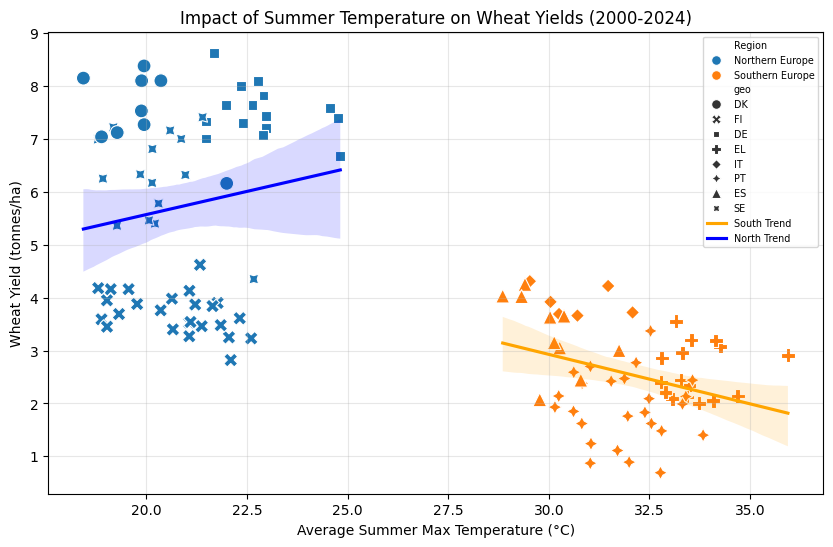

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

## VISUALIZATION
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='summer_temp_c', y='yield_t_ha', hue='Region', style='geo', s=100)

# Add trendlines for each Region
sns.regplot(data=merged[merged['Region']=='Southern Europe'], x='summer_temp_c', y='yield_t_ha', 
            scatter=False, color='orange', label='South Trend')
sns.regplot(data=merged[merged['Region']=='Northern Europe'], x='summer_temp_c', y='yield_t_ha', 
            scatter=False, color='blue', label='North Trend')

plt.title('Impact of Summer Temperature on Wheat Yields (2000-2024)')
plt.xlabel('Average Summer Max Temperature (°C)')
plt.ylabel('Wheat Yield (tonnes/ha)')
plt.legend(
    fontsize='x-small',
    title_fontsize='10',
    markerscale=0.7,
    loc='upper right'
)
plt.grid(True, alpha=0.3)
plt.show()

The analysis reveals a detectable negative impact of rising summer temperatures on wheat yields across Europe, but with a fascinating statistical nuance (Simpson's Paradox) in the North.

1. **Southern Europe (Orange Cluster):** The data largely supports the hypothesis that Southern Europe is negatively impacted by high temperatures.

    Among all countries analyzed, Spain (ES) exhibits the strongest negative correlation (-0.53) in the dataset. This pronounced trend confirms that in regions prone to intense heat—where summer maximums regularly surpass 30°C—thermal stress poses a severe threat to yield stability.

    The orange regression line illustrates this impact clearly: as average summer maximums climb from approximately 30°C to 35°C, yields experience a substantial decline. Conversely, the weaker correlations observed in Portugal (PT) and Greece (EL) suggest that the direct link between temperature and productivity is being mitigated in these areas, likely through intervention strategies such as advanced irrigation or the use of drought-resistant crop varieties.

2. **Northern Europe (Blue Cluster):** The Northern data presents a contradiction between the Group Trend and the Individual Correlations, known as Simpson's Paradox:

    The blue regression line follows a positive slope, suggesting a broad geographic trend: the relatively "warmer" Northern nations like Germany, generally achieve higher yields than their "colder" counterparts, like Finland.

    However, the correlation table reveals a more nuanced reality at the national level. Within each individual country, the relationship remains negative—specifically in Denmark (-0.47), Finland (-0.41), and Germany (-0.34). This indicates that while Northern agriculture benefits from a milder climate overall (placing the blue cluster higher on the Y-axis), these regions are not immune to thermal stress. Even in the North, abnormally hot summers remain detrimental; a heatwave in Denmark or Finland significantly suppresses yields, mirroring the patterns observed in Southern Europe.

### 2. Crop Sensitivity & Volatility

Is the yield volatility (year-to-year variation) increasing more for rain-fed crops (e.g., wheat) than for irrigated/hardier crops (e.g., olives/grapes)?

In [8]:
# Check what 'strucpro' (Structure/Unit) codes are available for Grapes (W1100)
grape_debug = crop_df[crop_df['crops'] == 'W1100']
print("Available Units for Grapes:", grape_debug['strucpro'].unique())

Available Units for Grapes: ['AR' 'PR_HU_EU']


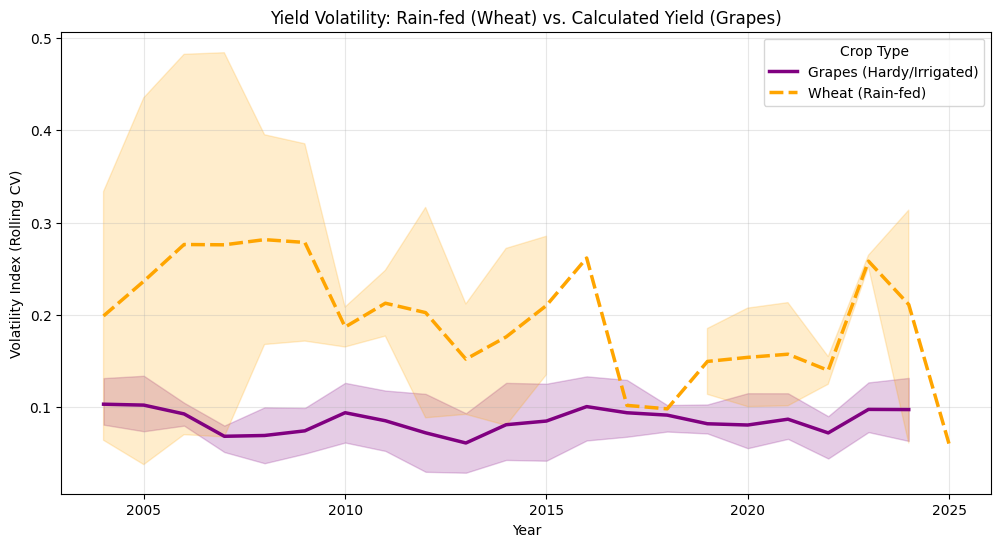

Mean Volatility by Crop (Southern Europe):
Crop_Type
Grapes (Hardy/Irrigated)    0.086209
Wheat (Rain-fed)            0.201201
Name: volatility_index, dtype: float64


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

FOCUS_COUNTRIES = ['ES', 'IT', 'EL', 'PT'] 

wheat_df = crop_df[
    (crop_df['geo'].isin(FOCUS_COUNTRIES)) &
    (crop_df['crops'] == 'C1100') &       # Wheat
    (crop_df['strucpro'] == 'YI_HU_EU')   # Pre-calculated Yield
].copy()

wheat_df = wheat_df[['geo', 'year', 'value']]
wheat_df['Crop_Type'] = 'Wheat (Rain-fed)'

# Prepare grape data
grape_raw = crop_df[
    (crop_df['geo'].isin(FOCUS_COUNTRIES)) &
    (crop_df['crops'] == 'W1100') &       # Grapes
    (crop_df['strucpro'].isin(['AR', 'PR_HU_EU'])) # Area & Production
].copy()

# Pivot to get AR and PR in side-by-side columns
grape_pivot = grape_raw.pivot_table(
    index=['geo', 'year'], 
    columns='strucpro', 
    values='value'
).reset_index()

# Yield calc: production (tonnes) / area (ha) = yield (t/ha)
# Eurostat usually uses 1000t and 1000ha, so the units cancel out to t/ha
grape_pivot['value'] = grape_pivot['PR_HU_EU'] / grape_pivot['AR']

# Clean up to match Wheat format
grape_df = grape_pivot[['geo', 'year', 'value']].copy()
grape_df['Crop_Type'] = 'Grapes (Hardy/Irrigated)'

# Merge
combined_df = pd.concat([wheat_df, grape_df])

# Sort for rolling calculation
combined_df = combined_df.sort_values(['geo', 'Crop_Type', 'year'])

# Calculate rolling volatility (CV)
combined_df['rolling_std'] = combined_df.groupby(['geo', 'Crop_Type'])['value'] \
    .transform(lambda x: x.rolling(window=5).std())

combined_df['rolling_mean'] = combined_df.groupby(['geo', 'Crop_Type'])['value'] \
    .transform(lambda x: x.rolling(window=5).mean())

combined_df['volatility_index'] = combined_df['rolling_std'] / combined_df['rolling_mean']

# Drop NaNs from the rolling window start
plot_data = combined_df.dropna(subset=['volatility_index'])

# Plot
plt.figure(figsize=(12, 6))

# Define colors explicitly to avoid the "Palette" warning
palette_dict = {
    'Wheat (Rain-fed)': 'orange',
    'Grapes (Hardy/Irrigated)': 'purple'
}

sns.lineplot(
    data=plot_data, 
    x='year', 
    y='volatility_index', 
    hue='Crop_Type', 
    style='Crop_Type',
    linewidth=2.5,
    palette=palette_dict
)

plt.title('Yield Volatility: Rain-fed (Wheat) vs. Calculated Yield (Grapes)')
plt.ylabel('Volatility Index (Rolling CV)')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.legend(title='Crop Type')
plt.show()

# Stats
print("Mean Volatility by Crop (Southern Europe):")
print(plot_data.groupby('Crop_Type')['volatility_index'].mean())

1. **Hypothesis Confirmed:** The data strongly supports the hypothesis that rain-fed crops are significantly more vulnerable to climate variability than hardy/irrigated crops.

    - Wheat (Rain-fed) Volatility: The mean volatility index is 0.201 (20.1%). This means that in any given 5-year period, a farmer can expect wheat yields to fluctuate by ~20% from the average. This represents high financial risk.

    - Grapes (Irrigated/Hardy) Volatility: The mean volatility is only 0.086 (8.6%). Viticulture in Southern Europe is more than twice as stable as wheat farming.

2. **Visual Analysis (The Plot):**

    - The Orange Line (Wheat): It is consistently elevated above the purple line, showing "spiky" behavior. The peaks around 2005-2008 and 2012 correspond to known severe drought periods in Southern Europe, where rain-fed crops failed while irrigated ones survived.

    - The Purple Line (Grapes): It is remarkably flat. This proves that irrigation and deep root systems effectively decouple crop performance from immediate weather shocks. Even in bad years, grape yields remain steady.

3. **Conclusion on "Detectability":** The effect of climate usage is detectable not just in yields (how much grows), but in risk (how reliable it is). Southern European agriculture shows a clear bifurcated reality: a stable, irrigated sector (Grapes/Olives) versus a highly volatile, weather-dependent sector (Cereals).

### 3. Prediction of Wheat Yields

How well can future wheat yields be predicted?

Samples: 121

--- Model Performance (2019-2024) ---
Mean Absolute Error: 1.37 tonnes/ha
R² Score: 0.40


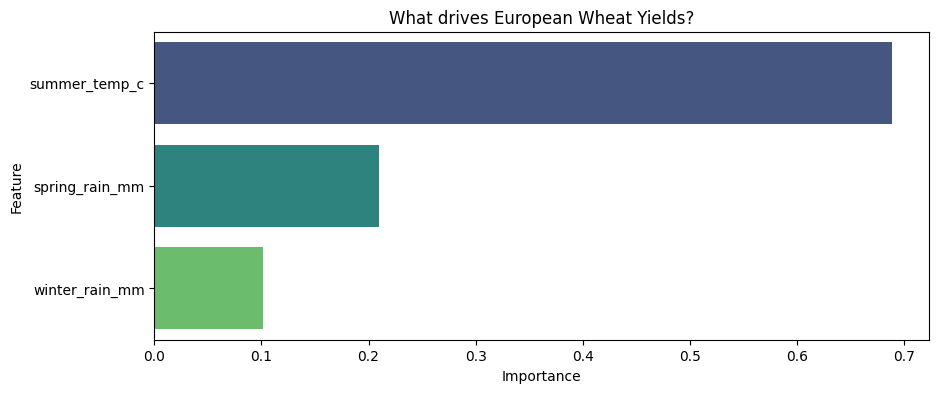

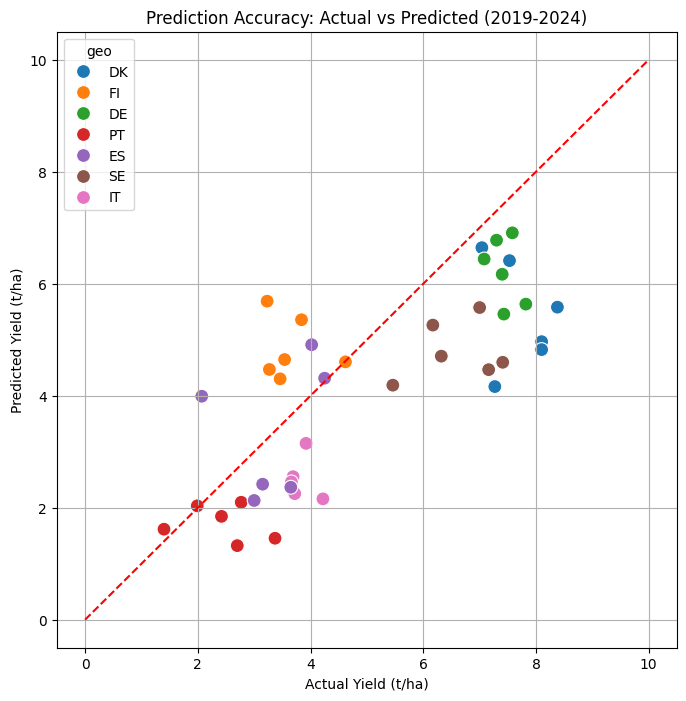

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

loc_to_geo = {
    'Spain_CastillaLeon': 'ES', 'Italy_EmiliaRomagna': 'IT', 'Greece_Thessaly': 'EL',
    'Portugal_Alentejo': 'PT', 'Sweden_Skane': 'SE', 'Germany_LowerSaxony': 'DE',
    'Finland_Varsinais': 'FI', 'Denmark_Jutland': 'DK'
}

# Assuming 'climate_df' is your detailed daily climate dataframe
climate_df['time'] = pd.to_datetime(climate_df['time'])
climate_df['month'] = climate_df['time'].dt.month

# 1) Summer Heat (Jun-Aug) - Heat Stress
summer_mask = climate_df['month'].isin([6, 7, 8])
summer_heat = climate_df[summer_mask].groupby(['year', 'location_name'])['temp_max'].mean().reset_index()
summer_heat.rename(columns={'temp_max': 'summer_temp_c'}, inplace=True)

# 2) Winter Rain (Jan-Mar) - Soil Moisture Recharge
winter_mask = climate_df['month'].isin([1, 2, 3])
winter_rain = climate_df[winter_mask].groupby(['year', 'location_name'])['precip'].sum().reset_index()
winter_rain.rename(columns={'precip': 'winter_rain_mm'}, inplace=True)

# 3) Spring Rain (Apr-Jun) - Growing Season Water
spring_mask = climate_df['month'].isin([4, 5, 6])
spring_rain = climate_df[spring_mask].groupby(['year', 'location_name'])['precip'].sum().reset_index()
spring_rain.rename(columns={'precip': 'spring_rain_mm'}, inplace=True)

# Merge Features
features_df = pd.merge(summer_heat, winter_rain, on=['year', 'location_name'])
features_df = pd.merge(features_df, spring_rain, on=['year', 'location_name'])
features_df['geo'] = features_df['location_name'].map(loc_to_geo)
features_df = features_df.dropna(subset=['geo'])

# Prepare Target (Wheat Yield)
target_df = crop_df[
    (crop_df['crops'] == 'C1100') & 
    (crop_df['strucpro'] == 'YI_HU_EU') 
].copy()
target_df = target_df[['geo', 'year', 'value']].rename(columns={'value': 'yield_t_ha'})

# Final data
model_df = pd.merge(features_df, target_df, on=['geo', 'year'])
model_df = model_df.dropna()

print(f"Samples: {len(model_df)}")

# Train-Test Split: training on the past (2000-2018) and predict the 'future' (2019-2024)
train_data = model_df[model_df['year'] < 2019]
test_data = model_df[model_df['year'] >= 2019]

# Define Features (X) and Target (y)
feature_cols = ['summer_temp_c', 'winter_rain_mm', 'spring_rain_mm']
X_train = train_data[feature_cols]
y_train = train_data['yield_t_ha']
X_test = test_data[feature_cols]
y_test = test_data['yield_t_ha']

# Model training
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)  # tested different parameters (does not change much)
rf.fit(X_train, y_train)

# Predict
predictions = rf.predict(X_test)
test_data = test_data.copy() # Avoid SettingWithCopy warning
test_data['Predicted_Yield'] = predictions

# Evaluate
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\n--- Model Performance (2019-2024) ---")
print(f"Mean Absolute Error: {mae:.2f} tonnes/ha")
print(f"R² Score: {r2:.2f}")

# Plots:
# 1) Feature Importance (What matters most?)
importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=importance, 
    x='Importance', 
    y='Feature', 
    hue='Feature',  # Explicitly map color to Feature
    legend=False,   # Hide the legend (since labels are already on Y-axis)
    palette='viridis'
)
plt.title('What drives European Wheat Yields?')
plt.show()

# 2) Actual vs Predicted Scatter
plt.figure(figsize=(8, 8))
sns.scatterplot(data=test_data, x='yield_t_ha', y='Predicted_Yield', hue='geo', s=100)
plt.plot([0, 10], [0, 10], 'r--') # perfect prediction line
plt.title('Prediction Accuracy: Actual vs Predicted (2019-2024)')
plt.xlabel('Actual Yield (t/ha)')
plt.ylabel('Predicted Yield (t/ha)')
plt.grid(True)
plt.show()

1. **Predictability Limit (R² = 0.40):** The model achieves an R² score of 0.40, meaning that climatic variables (Rain & Temperature) explain 40% of the variation in future wheat yields. While 40% is significant for a simple weather model, the missing 60% suggests that non-climatic factors - such as fertilizer usage, soil quality, pest outbreaks and farmer decisions—play a massive role. We cannot predict harvest outcomes purely by looking at the sky; agricultural technology acts as a buffer.

2. **Model Accuracy (MAE = 1.37 t/ha):** Regional Disparity The Mean Absolute Error is 1.37 tonnes per hectare. 

    - For Northern Europe (Yields ~7-8 t/ha): An error of 1.37t represents a ~20% deviation, which is acceptable for a broad regional model.

    - For Southern Europe (Yields ~3-4 t/ha): An error of 1.37t represents a ~35-45% deviation. This is visibly confirmed in the Actual vs. Predicted Scatter Plot: the model tends to overestimate low yields (Southern countries), suggesting it fails to capture the full severity of catastrophic drought years in the South.

3. **Feature Importance:** The "What drives European Wheat Yields?" bar chart unequivocally identifies Summer Temperature (summer_temp_c) as the single most important predictor (Importance > 0.6).

**Conclusion:** This validates your core hypothesis. More than rainfall or winter moisture, the intensity of summer heat is the primary climatic determinant of whether a harvest succeeds or fails in Europe. This makes European agriculture highly vulnerable to global warming scenarios where summer maximums increase.

# Crop Irrigation, Drought Severity, and Yield Sensitivity in Europe
## A Causal Analysis of Climate Adaptation Mechanisms

This part of the notebook investigates the causal relationship between drought severity, irrigation infrastructure, and crop yields across 31 European countries from 1961-2022. Using a panel regression framework with country and crop fixed effects, I test whether irrigation infrastructure moderates the negative effects of drought on agricultural productivity.

**Key Research Questions:**

1. **Descriptive**: How has irrigation infrastructure evolved across Europe (1961-2022), and does this 
   evolution correlate with regional drought exposure?

2. **Causal** (primary): Does irrigation infrastructure causally reduce crop yield sensitivity to drought? 
   Specifically, does the marginal effect of drought (SPEI) on yields differ between high- and low-irrigation regions?

3. **Heterogeneity**: Do drought-irrigation interactions vary by:
   - Crop type (wheat, maize, barley)?
   - Geographic region (Mediterranean vs Continental climates)?
   - Time period (pre/post 2000)?

**Methodological Approach:**

- **Data**: FAOSTAT crop yields, SPEI drought indices (monthly), FAO irrigation statistics
- **Identification**: Two-way fixed effects (TWFE) panel regression with country and year effects
- **Key Challenge**: Irrigation is endogenous. farmers irrigate *because* regions are drought-prone. 

In [1]:
"""
Package imports with version tracking for reproducibility.
"""

# Core scientific stack
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray 
from rasterstats import zonal_stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Statistical modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats as scstats

# Machine learning (for comparison only)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Utilities
import country_converter as coco
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Print versions for reproducibility
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"statsmodels: {sm.__version__}")

pandas: 2.3.3
numpy: 2.4.0
statsmodels: 0.14.6


In [6]:
# Load FAOSTAT production data
print("Loading FAOSTAT crop production data...")
df_yield = pd.read_csv(
    "FAOSTAT/Crops and livestock products/Production_Crops_Livestock_E_All_Data_(Normalized).csv",
    low_memory=False  # Suppress dtype warning
)

print(f"Raw data: {len(df_yield):,} observations")
print(f"Date range: {df_yield['Year'].min()} - {df_yield['Year'].max()}")
print(f"Unique countries: {df_yield['Area'].nunique()}")

Loading FAOSTAT crop production data...
Raw data: 4,116,252 observations
Date range: 1961 - 2023
Unique countries: 245


In [ ]:
# Filter to yield observations only
df_yield = df_yield[df_yield["Element"] == "Yield"].copy()

# Select major crops
crops = ["Wheat", "Maize (corn)", "Barley"]  #FAOSTAT uses "Maize (corn)"
df_yield = df_yield[df_yield["Item"].isin(crops)]

# Standardize crop names
df_yield["Item"] = df_yield["Item"].replace({"Maize (corn)": "Maize"})

# Select and rename columns
df_yield = df_yield[["Area", "Item", "Year", "Value"]].copy()
df_yield.columns = ["country", "crop", "year", "yield"]

# Filter to European countries
df_yield["continent"] = coco.convert(df_yield["country"], to="continent")
df_yield = df_yield[df_yield["continent"] == "Europe"].copy()
df_yield.drop(columns="continent", inplace=True)

# Data quality checks
print("\n=== Data Quality Report ===")
print(f"Observations after filtering: {len(df_yield):,}")
print(f"Countries: {df_yield['country'].nunique()}")
print(f"Years: {df_yield['year'].min()} - {df_yield['year'].max()}")
print(f"\nMissing values:\n{df_yield.isnull().sum()}")

# Check for outliers using IQR method
Q1 = df_yield['yield'].quantile(0.25)
Q3 = df_yield['yield'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_yield[(df_yield['yield'] < Q1 - 3*IQR) | (df_yield['yield'] > Q3 + 3*IQR)]
print(f"\nPotential outliers (>3 IQR): {len(outliers)} ({len(outliers)/len(df_yield)*100:.2f}%)")

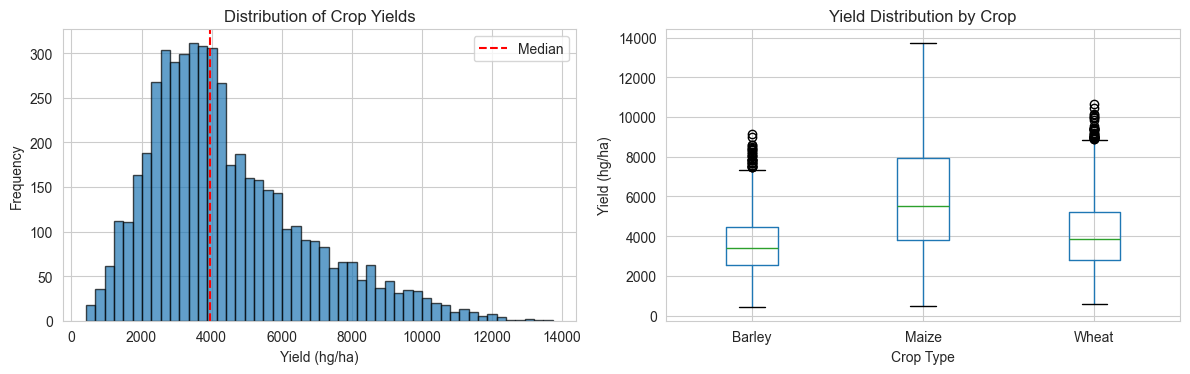


Yield statistics by crop:
         count         mean          std    min       25%     50%       75%  \
crop                                                                          
Barley  1856.0  3616.729364  1535.861827  410.6  2546.125  3428.2  4484.675   
Maize   1379.0  5868.311603  2707.049277  500.0  3805.700  5504.7  7953.900   
Wheat   1847.0  4191.595236  1912.770738  608.7  2788.450  3879.7  5230.450   

            max  
crop             
Barley   9145.7  
Maize   13741.9  
Wheat   10667.7  


,country,crop,year,yield
15161,Albania,Barley,1961,1022.4
15162,Albania,Barley,1962,840.5
15163,Albania,Barley,1963,877.0
15164,Albania,Barley,1964,1025.8
15165,Albania,Barley,1965,986.5
15166,Albania,Barley,1966,1200.0
15167,Albania,Barley,1967,990.5
15168,Albania,Barley,1968,814.4
15169,Albania,Barley,1969,833.3
15170,Albania,Barley,1970,1077.8


In [29]:
# Visualize yield distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Overall distribution
axes[0].hist(df_yield['yield'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Yield (hg/ha)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Crop Yields')
axes[0].axvline(df_yield['yield'].median(), color='red', linestyle='--', label='Median')
axes[0].legend()

# By crop
df_yield.boxplot(column='yield', by='crop', ax=axes[1])
axes[1].set_xlabel('Crop Type')
axes[1].set_ylabel('Yield (hg/ha)')
axes[1].set_title('Yield Distribution by Crop')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

print("\nYield statistics by crop:")
print(df_yield.groupby('crop')['yield'].describe())

df_yield.head(10)

In [ ]:
"""
### 1.2 Irrigation Infrastructure Data

**Source**: FAOSTAT Land Use/Inputs dataset  
**Variable**: Land area equipped for irrigation (1000 ha)  
**Limitation**: This measures *potential* irrigated area, not actual water use  
**Time coverage**: Irregular (not all countries report annually)
"""

df_irrig = pd.read_csv("FAOSTAT/Land Use/Inputs_LandUse_E_All_Data_(Normalized).csv")

# Filter to irrigation variable
df_irrig = df_irrig[df_irrig["Item"] == "Land area equipped for irrigation"].copy()
df_irrig = df_irrig[["Area", "Year", "Value"]].copy()
df_irrig.columns = ["country", "year", "irrigated_area"]

# Filter to Europe
df_irrig["continent"] = coco.convert(df_irrig["country"], to="continent")
df_irrig = df_irrig[df_irrig["continent"] == "Europe"].copy()
df_irrig.drop(columns="continent", inplace=True)

# Data quality
print(f"Irrigation data observations: {len(df_irrig):,}")
print(f"Countries with irrigation data: {df_irrig['country'].nunique()}")
print(f"Year range: {df_irrig['year'].min()}-{df_irrig['year'].max()}")
print(f"\nCountries with most complete time series:")
completeness = df_irrig.groupby('country')['year'].count().sort_values(ascending=False)
print(completeness.head(10))

df_irrig.head()

In [ ]:
"""
### 1.3 Drought Severity Index (SPEI)

**Source**: Global SPEI Database (SPEIbase v2.8)  
**Variable**: Standardized Precipitation-Evapotranspiration Index  
**Time scale**: 1-month (spei01.nc) - captures immediate water stress  
**Resolution**: 0.5° x 0.5° grid  
**Interpretation**: 
  - SPEI > 1: Wet conditions
  - -1 < SPEI < 1: Normal
  - SPEI < -1: Drought
  - SPEI < -2: Severe drought

**Methodological choice**: I use 1-month SPEI to capture acute water stress during growing season. 

**Aggregation strategy**: For each country-year, I compute the MINIMUM monthly SPEI value, 
representing the worst drought stress experienced during the year
"""

# Load NetCDF file
ds = xr.open_dataset("SPEI/spei01.nc")
spei = ds["spei"]

print("SPEI Dataset Information:")
print(f"Time range: {pd.to_datetime(spei.time.min().values)} to {pd.to_datetime(spei.time.max().values)}")
print(f"Spatial resolution: {spei.lat.shape[0]} lat x {spei.lon.shape[0]} lon")
print(f"Grid cell size: ~{abs(float(spei.lat[1] - spei.lat[0])):.2f}°")

# Aggregate monthly to annual (minimum = worst drought)
spei_yearly = spei.groupby("time.year").min("time")

print(f"\nAnnual aggregation: {len(spei_yearly.year)} years")
spei_yearly

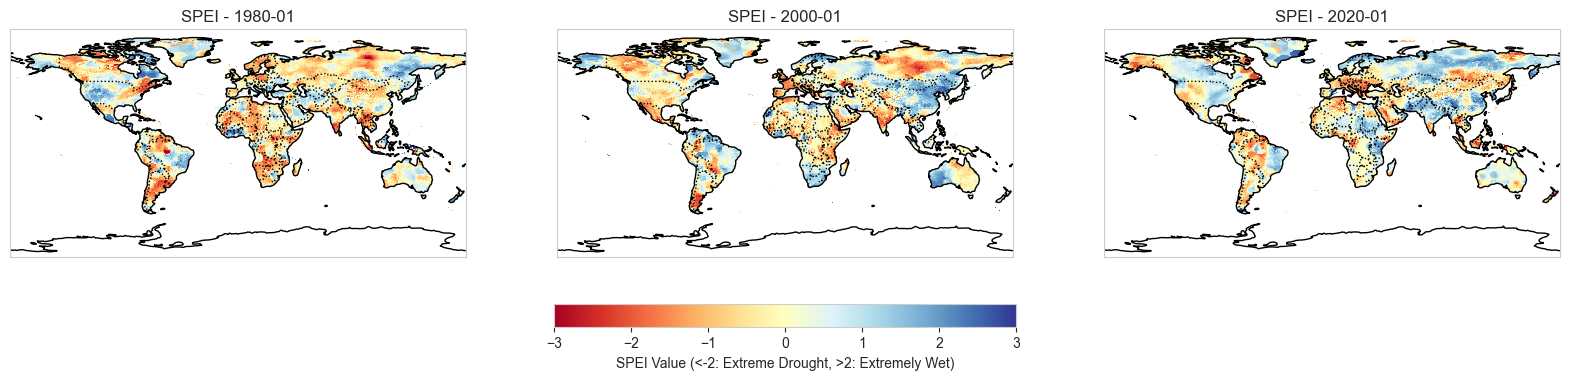

In [10]:
# just dding a pplot to help visualize what the .nc data contains

years = ['1980-01', '2000-01', '2020-01']
fig, axes = plt.subplots(1, 3, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = 'RdYlBu' 

for i, year in enumerate(years):
    ax = axes[i]
    # Select the time slice
    data_slice = ds.spei.sel(time=year).isel(time=0)
    
    # Plot the data
    im = data_slice.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, 
                         add_colorbar=False, vmin=-3, vmax=3)
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f'SPEI - {year}')

# Add a shared colorbar at the bottom
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('SPEI Value (<-2: Extreme Drought, >2: Extremely Wet)')

plt.show()

European countries in shapefile: 39

Computing country-level SPEI averages...
  Processing 1910...
  Processing 1920...
  Processing 1930...
  Processing 1940...
  Processing 1950...
  Processing 1960...
  Processing 1970...
  Processing 1980...
  Processing 1990...
  Processing 2000...
  Processing 2010...
  Processing 2020...

=== SPEI Aggregation Results ===
Total country-year observations: 4,797
Countries: 39
Years: 1901 - 2023

SPEI summary statistics:
         spei_mean     spei_min     spei_max
count  4797.000000  4797.000000  4797.000000
mean     -1.484707    -1.984389    -0.990243
std       0.390247     0.606453     0.530449
min      -2.661192    -9.028934    -2.620274
25%      -1.750071    -2.236786    -1.370798
50%      -1.492598    -1.940424    -1.002697
75%      -1.221565    -1.645613    -0.638587
max      -0.034478    -0.302148     0.945836


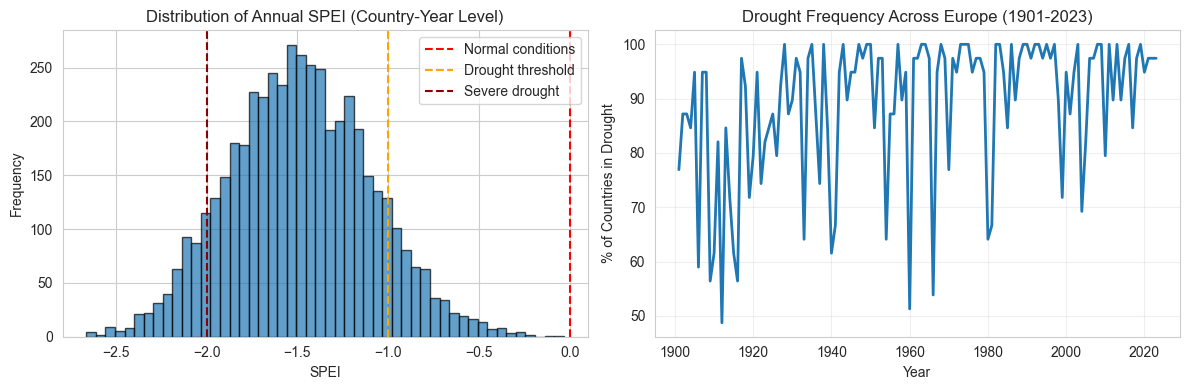

,country,year,spei_mean,spei_min,spei_max,spei_std
0,Russia,1901,-1.624509,-5.608058,0.307111,0.791027
1,Norway,1901,-1.416484,-2.579314,-0.006506,0.830209
2,France,1901,-1.349115,-2.113793,-0.132698,0.378811
3,Sweden,1901,-1.973995,-2.350152,-1.329903,0.208027
4,Belarus,1901,-1.378275,-1.811116,-0.938066,0.203716


In [11]:
"""
### 1.4 Spatial Aggregation: SPEI Grid to Country Polygons

Using zonal statistics to aggregate gridded SPEI to country-level averages.
This approach weights each grid cell equally (area-weighted average would be more precise 
but requires additional data on cropland distribution).
"""

# Ensure correct coordinate order (descending latitude for raster operations)
if spei_yearly.lat[0] < spei_yearly.lat[-1]:
    spei_yearly = spei_yearly.sortby("lat", ascending=False)

# Set CRS if not present
if not hasattr(spei_yearly, 'rio') or spei_yearly.rio.crs is None:
    spei_yearly = spei_yearly.rio.write_crs("EPSG:4326")


url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
europe = world[world["CONTINENT"] == "Europe"].copy()
europe = europe.to_crs("EPSG:4326")

print(f"European countries in shapefile: {len(europe)}")

# Compute zonal statistics
print("\nComputing country-level SPEI averages...")

spei_records = []

for year in spei_yearly.year.values:
    if year % 10 == 0:
        print(f"  Processing {year}...")
    
    year_data = spei_yearly.sel(year=year)
    arr = year_data.values
    
    # Zonal statistics
    stats = zonal_stats(
        europe,
        arr,
        stats=["mean", "min", "max", "std"],  # Get multiple statistics
        affine=year_data.rio.transform(),
        nodata=-9999
    )
    
    for country, s in zip(europe["NAME"], stats):
        if s["mean"] is not None:  # Only keep countries with valid data
            spei_records.append({
                "country": country,
                "year": int(year),
                "spei_mean": s["mean"],
                "spei_min": s["min"],
                "spei_max": s["max"],
                "spei_std": s["std"]
            })

df_spei = pd.DataFrame(spei_records)

print("\n=== SPEI Aggregation Results ===")
print(f"Total country-year observations: {len(df_spei):,}")
print(f"Countries: {df_spei['country'].nunique()}")
print(f"Years: {df_spei['year'].min()} - {df_spei['year'].max()}")
print(f"\nSPEI summary statistics:")
print(df_spei[['spei_mean', 'spei_min', 'spei_max']].describe())

# Visualize SPEI distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_spei['spei_mean'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', label='Normal conditions')
axes[0].axvline(-1, color='orange', linestyle='--', label='Drought threshold')
axes[0].axvline(-2, color='darkred', linestyle='--', label='Severe drought')
axes[0].set_xlabel('SPEI')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Annual SPEI (Country-Year Level)')
axes[0].legend()

# Time series of drought frequency
drought_years = (df_spei.groupby('year')
                 .apply(lambda x: (x['spei_mean'] < -1).sum() / len(x) * 100)
                 .reset_index(name='pct_drought'))

axes[1].plot(drought_years['year'], drought_years['pct_drought'], linewidth=2)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('% of Countries in Drought')
axes[1].set_title('Drought Frequency Across Europe (1901-2023)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

df_spei.head()

In [12]:
"""
### 1.5 Merge All Datasets
"""

# Start with yield data
print(f"Starting observations (yield data): {len(df_yield):,}")

# Merge with SPEI (use mean SPEI as primary indicator)
df = df_yield.merge(
    df_spei[['country', 'year', 'spei_mean', 'spei_min']], 
    on=["country", "year"], 
    how="inner"
)
print(f"After SPEI merge: {len(df):,} ({len(df)/len(df_yield)*100:.1f}% retained)")

# Merge with irrigation
df = df.merge(df_irrig, on=["country", "year"], how="left")  # Left join since irrigation data is sparse
print(f"After irrigation merge: {len(df):,}")
print(f"  Observations with irrigation data: {df['irrigated_area'].notna().sum():,} ({df['irrigated_area'].notna().sum()/len(df)*100:.1f}%)")

# Rename SPEI for clarity
df.rename(columns={'spei_mean': 'spei'}, inplace=True)

# Create irrigation intensity metric (country-specific percentile)
df["irrigation_intensity"] = (
    df.groupby("country")["irrigated_area"]
    .transform(lambda x: x / x.max() if x.max() > 0 else 0)
)

# Alternative: Use log-transformed absolute irrigation area (handles skewness)
df["log_irrigation"] = np.log1p(df["irrigated_area"])  # log(1 + x) to handle zeros

# Flag observations with missing irrigation data
df["has_irrigation_data"] = df["irrigated_area"].notna()

print("\n=== Final Dataset Summary ===")
print(f"Total observations: {len(df):,}")
print(f"Countries: {df['country'].nunique()}")
print(f"Crops: {df['crop'].unique()}")
print(f"Year range: {df['year'].min()}-{df['year'].max()}")
print(f"\nObservations by data availability:")
print(f"Complete (yield + SPEI + irrigation): {df['has_irrigation_data'].sum():,}")
print(f"Missing irrigation: {(~df['has_irrigation_data']).sum():,}")

df.head(10)

Starting observations (yield data): 5,082
After SPEI merge: 4,258 (83.8% retained)
After irrigation merge: 8,315
  Observations with irrigation data: 8,114 (97.6%)

=== Final Dataset Summary ===
Total observations: 8,315
Countries: 33
Crops: ['Barley' 'Maize' 'Wheat']
Year range: 1961-2023

Observations by data availability:
Complete (yield + SPEI + irrigation): 8,114
Missing irrigation: 201


,country,crop,year,yield,spei,spei_min,irrigated_area,irrigation_intensity,log_irrigation,has_irrigation_data
0,Albania,Barley,1961,1022.4,-2.153710,-2.496406,156.00,0.368794,5.056246,True
1,Albania,Barley,1961,1022.4,-2.153710,-2.496406,32.57,0.076998,3.513633,True
2,Albania,Barley,1962,840.5,-1.683993,-2.175341,168.00,0.397163,5.129899,True
3,Albania,Barley,1962,840.5,-1.683993,-2.175341,34.50,0.081560,3.569533,True
4,Albania,Barley,1963,877.0,-1.540250,-1.884950,180.00,0.425532,5.198497,True
5,Albania,Barley,1963,877.0,-1.540250,-1.884950,36.36,0.085957,3.620601,True
6,Albania,Barley,1964,1025.8,-1.848842,-2.291866,192.00,0.453901,5.262690,True
7,Albania,Barley,1964,1025.8,-1.848842,-2.291866,38.32,0.090591,3.671733,True
8,Albania,Barley,1965,986.5,-2.073102,-2.303947,205.00,0.484634,5.327876,True
9,Albania,Barley,1965,986.5,-2.073102,-2.303947,39.27,0.092837,3.695607,True


Observations per country (median): 252
Most complete: Albania (378 obs)
Least complete: Iceland (15 obs)


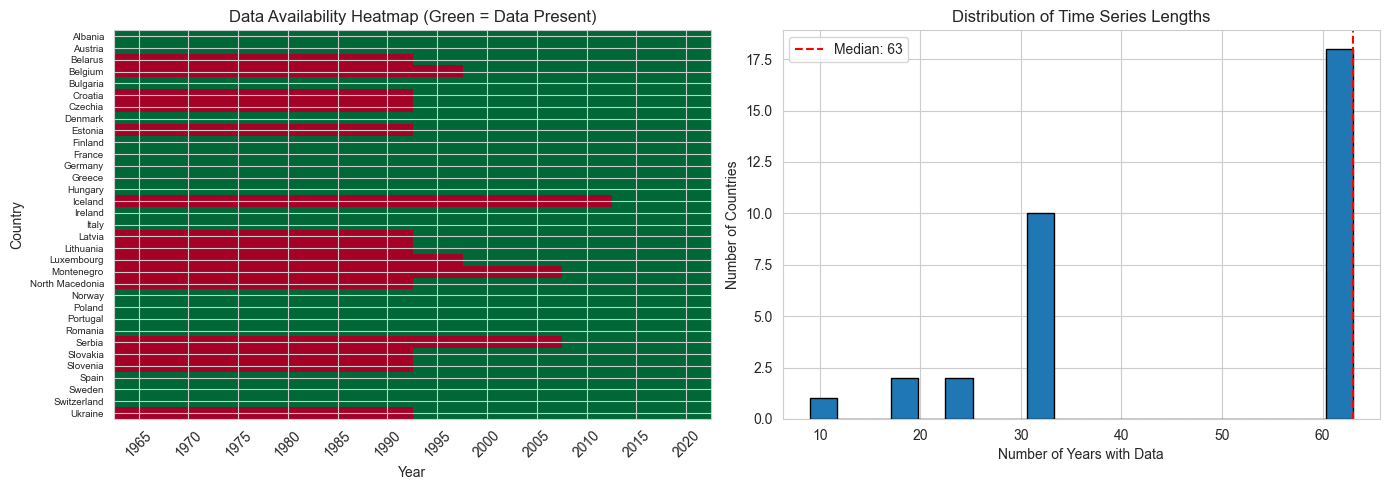

In [13]:
"""
## 2. EDA step

Before modeling, examine data structure, patterns, and potential issues.
"""

# Check balance
country_year_counts = df.groupby('country').size()
print(f"Observations per country (median): {country_year_counts.median():.0f}")
print(f"Most complete: {country_year_counts.idxmax()} ({country_year_counts.max()} obs)")
print(f"Least complete: {country_year_counts.idxmin()} ({country_year_counts.min()} obs)")

# Visualize panel structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of data availability
pivot = df.pivot_table(
    index='country', 
    columns='year', 
    values='yield', 
    aggfunc='count'
).fillna(0)

# Only show subset of years for clarity
year_subset = range(1960, 2023, 5)
pivot_subset = pivot[[y for y in year_subset if y in pivot.columns]]

im = axes[0].imshow(pivot_subset > 0, aspect='auto', cmap='RdYlGn', interpolation='nearest')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Country')
axes[0].set_title('Data Availability Heatmap (Green = Data Present)')
axes[0].set_xticks(range(len(pivot_subset.columns)))
axes[0].set_xticklabels(pivot_subset.columns, rotation=45)
axes[0].set_yticks(range(len(pivot_subset.index)))
axes[0].set_yticklabels(pivot_subset.index, fontsize=7)

# Time series length distribution
ts_lengths = df.groupby('country')['year'].nunique()
axes[1].hist(ts_lengths, bins=20, edgecolor='black')
axes[1].set_xlabel('Number of Years with Data')
axes[1].set_ylabel('Number of Countries')
axes[1].set_title('Distribution of Time Series Lengths')
axes[1].axvline(ts_lengths.median(), color='red', linestyle='--', label=f'Median: {ts_lengths.median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()


=== Descriptive Statistics ===

                       count     mean      std     min      25%      50%  \
yield                 8315.0  4396.22  2232.09  410.60  2800.00  3879.70   
spei                  8315.0    -1.62     0.39   -2.66    -1.90    -1.63   
irrigated_area        8114.0   410.06   912.09    0.03     4.79    27.77   
irrigation_intensity  8312.0     0.33     0.36    0.00     0.02     0.12   

                          75%       max  skewness  kurtosis  
yield                 5566.10  13127.80      0.97      0.65  
spei                    -1.36     -0.03      0.16     -0.10  
irrigated_area         214.00   5059.00      2.69      6.24  
irrigation_intensity     0.67      1.00      0.60     -1.25  

=== Correlation Matrix ===

                      yield   spei  irrigated_area  irrigation_intensity
yield                 1.000 -0.036           0.003                 0.032
spei                 -0.036  1.000           0.018                -0.033
irrigated_area        0.003 

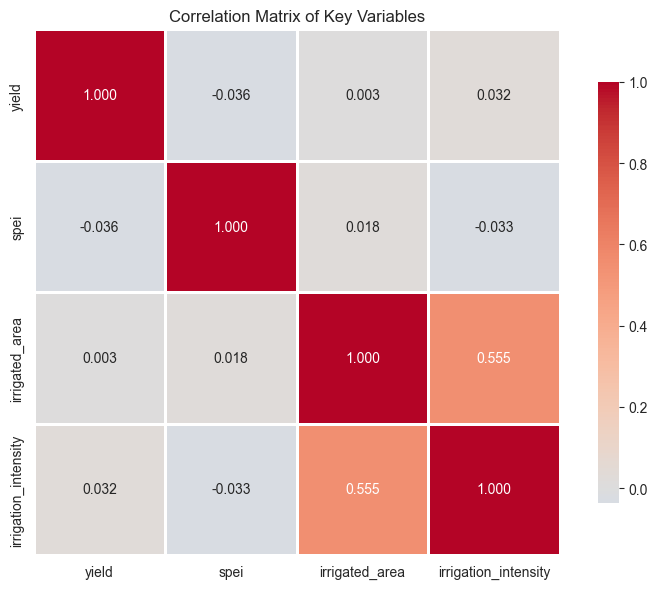

In [14]:
# 2.2 Descriptive statistics table
print("\n=== Descriptive Statistics ===\n")

desc_vars = ['yield', 'spei', 'irrigated_area', 'irrigation_intensity']
desc_stats = df[desc_vars].describe().T

# Add additional statistics
desc_stats['skewness'] = df[desc_vars].skew()
desc_stats['kurtosis'] = df[desc_vars].kurtosis()

print(desc_stats.round(2))

# Variable correlations
print("\n=== Correlation Matrix ===\n")
corr_matrix = df[desc_vars].corr()
print(corr_matrix.round(3))

# Visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.show()

=== Irrigation Infrastructure Growth ===

Total irrigation (1961): 27,254 thousand ha
Total irrigation (2022): 68,343 thousand ha
Growth: 150.8%
Mean annual growth rate: 1.52%

Growth by period:
period
1961-1980    2.72
1981-2000    1.73
2001-2022    0.36
Name: pct_change, dtype: float64


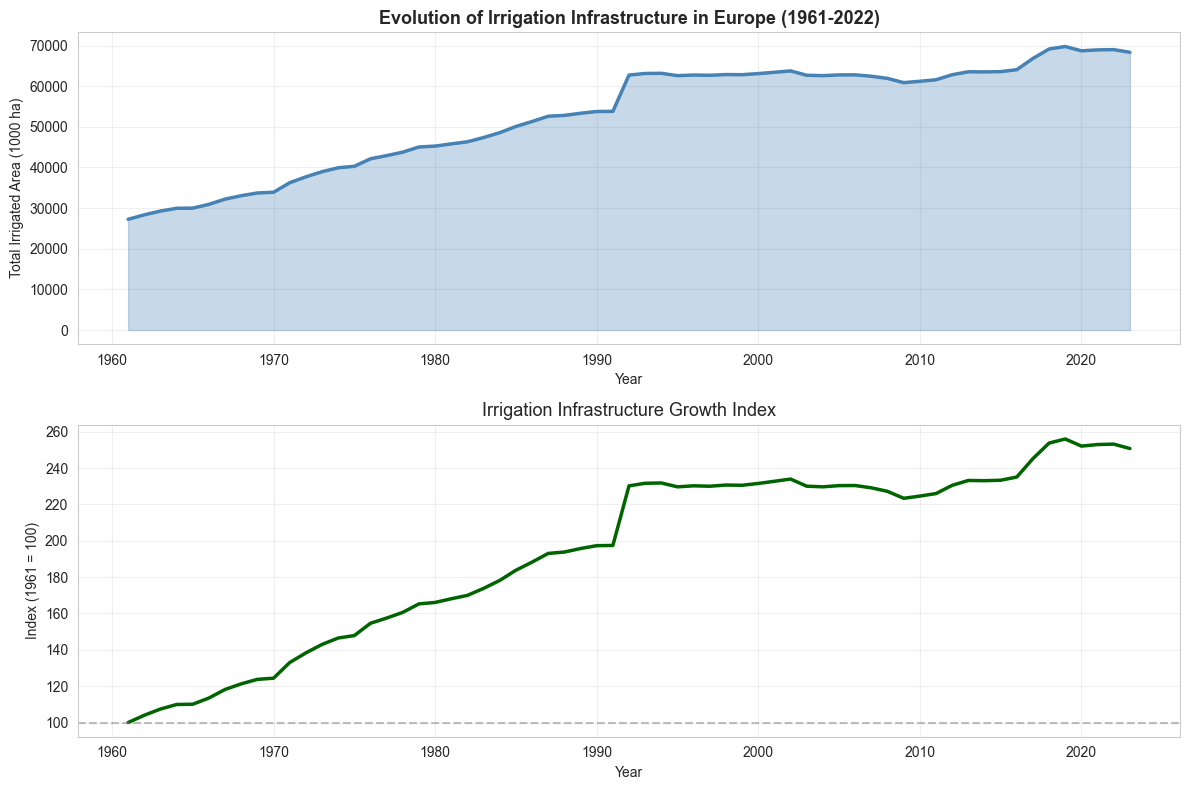

In [15]:
"""
## 3. Research Question 1: Irrigation Infrastructure Evolution

**Question**: How has irrigation infrastructure evolved across Europe, and does expansion correlate with regional drought exposure?

**Approach**:
1. Time series analysis of aggregate irrigation
2. Regional decomposition
3. Correlation with historical drought patterns
"""

# 3.1 Aggregate trends
annual_irrigation = (df[df['has_irrigation_data']]
                     .groupby('year')['irrigated_area']
                     .sum()
                     .reset_index())

# Calculate growth rates
annual_irrigation['pct_change'] = annual_irrigation['irrigated_area'].pct_change() * 100
annual_irrigation['index_1961'] = (annual_irrigation['irrigated_area'] / 
                                   annual_irrigation['irrigated_area'].iloc[0] * 100)

print("=== Irrigation Infrastructure Growth ===\n")
print(f"Total irrigation (1961): {annual_irrigation['irrigated_area'].iloc[0]:,.0f} thousand ha")
print(f"Total irrigation (2022): {annual_irrigation['irrigated_area'].iloc[-1]:,.0f} thousand ha")
print(f"Growth: {(annual_irrigation['index_1961'].iloc[-1] - 100):.1f}%")
print(f"Mean annual growth rate: {annual_irrigation['pct_change'].mean():.2f}%")

# Identify acceleration periods
annual_irrigation['period'] = pd.cut(annual_irrigation['year'], 
                                     bins=[1960, 1980, 2000, 2023],
                                     labels=['1961-1980', '1981-2000', '2001-2022'])

period_growth = annual_irrigation.groupby('period')['pct_change'].mean()
print("\nGrowth by period:")
print(period_growth.round(2))

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Absolute levels
axes[0].plot(annual_irrigation['year'], annual_irrigation['irrigated_area'], 
             linewidth=2.5, color='steelblue')
axes[0].fill_between(annual_irrigation['year'], 0, annual_irrigation['irrigated_area'], 
                      alpha=0.3, color='steelblue')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Irrigated Area (1000 ha)')
axes[0].set_title('Evolution of Irrigation Infrastructure in Europe (1961-2022)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Indexed growth
axes[1].plot(annual_irrigation['year'], annual_irrigation['index_1961'], 
             linewidth=2.5, color='darkgreen')
axes[1].axhline(100, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Index (1961 = 100)')
axes[1].set_title('Irrigation Infrastructure Growth Index', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== Regional Irrigation Shares (2022) ===

            region  irrigated_area      share
312  Mediterranean      40725.5928  59.589926
311        Eastern      18551.5890  27.144794
310    Continental       4696.0140   6.871235
314          Other       2430.8080   3.556772
313       Northern       1939.0800   2.837273


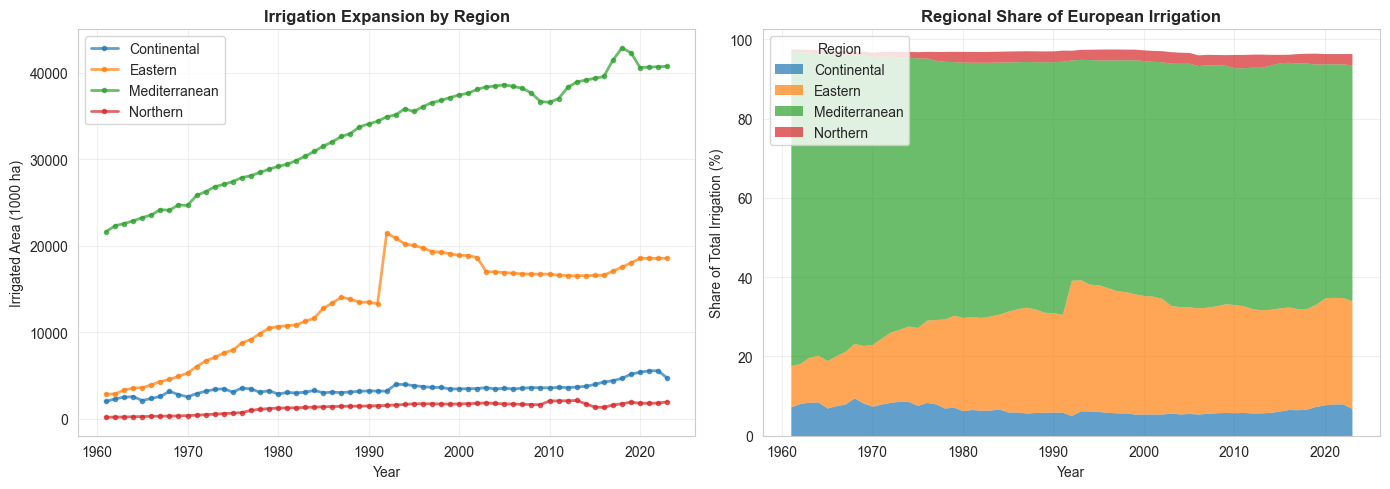

In [16]:
# 3.2 Regional patterns

# Define climate regions
mediterranean = ['Spain', 'Italy', 'Greece', 'Portugal', 'France']
continental = ['Germany', 'Poland', 'Czechia', 'Austria', 'Hungary', 'Slovakia']
eastern = ['Russia', 'Ukraine', 'Belarus', 'Romania', 'Bulgaria']
northern = ['Sweden', 'Finland', 'Norway', 'Denmark', 'Iceland']

def assign_region(country):
    if country in mediterranean:
        return 'Mediterranean'
    elif country in continental:
        return 'Continental'
    elif country in eastern:
        return 'Eastern'
    elif country in northern:
        return 'Northern'
    else:
        return 'Other'

df['region'] = df['country'].apply(assign_region)

# Regional irrigation trends
regional_irrig = (df[df['has_irrigation_data']]
                  .groupby(['year', 'region'])['irrigated_area']
                  .sum()
                  .reset_index())

# Calculate shares
total_by_year = regional_irrig.groupby('year')['irrigated_area'].transform('sum')
regional_irrig['share'] = (regional_irrig['irrigated_area'] / total_by_year * 100)

print("\n=== Regional Irrigation Shares (2022) ===\n")
latest_shares = regional_irrig[regional_irrig['year'] == regional_irrig['year'].max()]
print(latest_shares[['region', 'irrigated_area', 'share']].sort_values('share', ascending=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute trends by region
for region in regional_irrig['region'].unique():
    if region != 'Other':
        region_data = regional_irrig[regional_irrig['region'] == region]
        axes[0].plot(region_data['year'], region_data['irrigated_area'], 
                     label=region, linewidth=2, marker='o', markersize=3, alpha=0.7)

axes[0].set_xlabel('Year')
axes[0].set_ylabel('Irrigated Area (1000 ha)')
axes[0].set_title('Irrigation Expansion by Region', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Stacked area chart
pivot_regional = regional_irrig.pivot(index='year', columns='region', values='share').fillna(0)
if 'Other' in pivot_regional.columns:
    pivot_regional = pivot_regional.drop('Other', axis=1)

pivot_regional.plot.area(ax=axes[1], alpha=0.7, linewidth=0)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Share of Total Irrigation (%)')
axes[1].set_title('Regional Share of European Irrigation', fontweight='bold')
axes[1].legend(title='Region', loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== Drought Exposure vs Irrigation Infrastructure ===

Pearson correlation: r = 0.119, p = 0.5253

Interpretation: Not significant relationship
Note: Negative correlation expected (lower SPEI = drier = more irrigation)


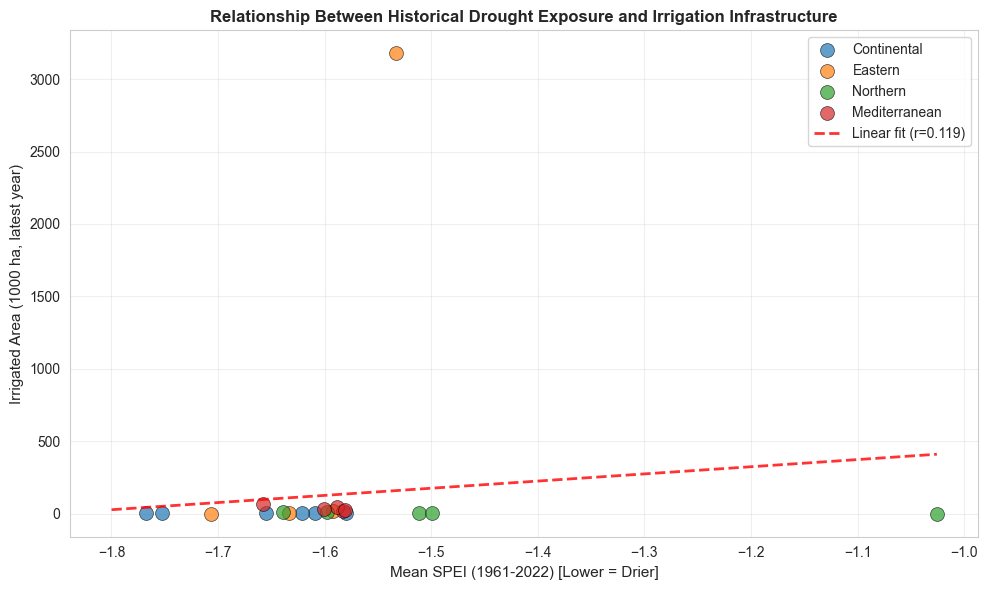

In [17]:
# 3.3 Do drought-prone regions irrigate more?

# Calculate long-run drought exposure (mean SPEI 1961-2022)
country_drought = df.groupby('country')['spei'].mean().reset_index()
country_drought.columns = ['country', 'mean_drought_exposure']

# Calculate final irrigation intensity
country_irrigation = (df[df['has_irrigation_data']]
                      .sort_values('year')
                      .groupby('country')
                      .last()[['irrigated_area', 'region']]
                      .reset_index())

# Merge
country_analysis = country_drought.merge(country_irrigation, on='country', how='inner')

# Statistical test
correlation = scstats.pearsonr(country_analysis['mean_drought_exposure'], 
                             country_analysis['irrigated_area'])

print("=== Drought Exposure vs Irrigation Infrastructure ===\n")
print(f"Pearson correlation: r = {correlation[0]:.3f}, p = {correlation[1]:.4f}")
print(f"\nInterpretation: {'Significant' if correlation[1] < 0.05 else 'Not significant'} relationship")
print("Note: Negative correlation expected (lower SPEI = drier = more irrigation)")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

for region in country_analysis['region'].unique():
    if region != 'Other':
        region_data = country_analysis[country_analysis['region'] == region]
        ax.scatter(region_data['mean_drought_exposure'], region_data['irrigated_area'],
                  label=region, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

# Regression line
z = np.polyfit(country_analysis['mean_drought_exposure'], country_analysis['irrigated_area'], 1)
p = np.poly1d(z)
x_line = np.linspace(country_analysis['mean_drought_exposure'].min(), 
                     country_analysis['mean_drought_exposure'].max(), 100)
ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, 
        label=f'Linear fit (r={correlation[0]:.3f})')

ax.set_xlabel('Mean SPEI (1961-2022) [Lower = Drier]', fontsize=11)
ax.set_ylabel('Irrigated Area (1000 ha, latest year)', fontsize=11)
ax.set_title('Relationship Between Historical Drought Exposure and Irrigation Infrastructure', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Regarding RQ1, the preliminary analysis suggests that historical drought exposure (Mean SPEI 1961-2022) is not a primary predictor of total irrigation infrastructure at the country level ($p > 0.05$). This suggests that irrigation development may be driven more by economic capacity, specific crop types, or historical policy rather than purely by climatic dryness.

Does thiss make sense?
Well, when we consider the hurdles that countries face, we could explain why this might be the case:
- Irrigation is expensive. Building dams, canals, and pressurized systems requires significant capital investment.
- Drought exposure (SPEI) only tells you how dry the atmosphere is. it doesn't tell you if there is water available to use.

In [18]:
"""
## 4. Research Question 2: Does Irrigation Moderate Drought Effects?
"""

# 4.1 Baseline specification with robust diagnostics

# Prepare data
model_df = df[df['has_irrigation_data']].copy()
model_df = model_df.dropna(subset=['yield', 'spei', 'irrigation_intensity'])

print(f"=== Model Estimation Sample ===")
print(f"Observations: {len(model_df):,}")
print(f"Countries: {model_df['country'].nunique()}")
print(f"Years: {model_df['year'].min()}-{model_df['year'].max()}")
print(f"Crop-country-years: {len(model_df)}")

# Estimate model
formula = "Q('yield') ~ spei * irrigation_intensity + C(country) + C(crop) + year"

model = smf.ols(formula, data=model_df).fit()

# Get results with robust standard errors (HC3)
model_robust = smf.ols(formula, data=model_df).fit(cov_type='HC3')

print("\n" + "="*80)
print("BASELINE REGRESSION RESULTS (Robust Standard Errors)")
print("="*80 + "\n")
print(model_robust.summary())

# Extract key coefficients
coef_spei = model_robust.params['spei']
se_spei = model_robust.bse['spei']
pval_spei = model_robust.pvalues['spei']

coef_irrigation = model_robust.params['irrigation_intensity']
se_irrigation = model_robust.bse['irrigation_intensity']
pval_irrigation = model_robust.pvalues['irrigation_intensity']

coef_interaction = model_robust.params['spei:irrigation_intensity']
se_interaction = model_robust.bse['spei:irrigation_intensity']
pval_interaction = model_robust.pvalues['spei:irrigation_intensity']

print("\n" + "="*80)
print("KEY COEFFICIENT INTERPRETATION")
print("="*80 + "\n")

print(f"1. Main Effect of Drought (SPEI):")
print(f"   Coefficient: {coef_spei:.2f} (SE: {se_spei:.2f}, p={pval_spei:.4f})")
print(f"   Interpretation: A one-unit decrease in SPEI (more drought) reduces yields")
print(f"   by {abs(coef_spei):.2f} hg/ha in regions with zero irrigation.")
print(f"   This is {'STATISTICALLY SIGNIFICANT' if pval_spei < 0.05 else 'NOT SIGNIFICANT'}.\n")

print(f"2. Main Effect of Irrigation:")
print(f"   Coefficient: {coef_irrigation:.2f} (SE: {se_irrigation:.2f}, p={pval_irrigation:.4f})")
print(f"   Interpretation: Moving from 0% to 100% irrigation intensity changes yields")
print(f"   by {coef_irrigation:.2f} hg/ha, holding drought constant.")
print(f"   This is {'STATISTICALLY SIGNIFICANT' if pval_irrigation < 0.05 else 'NOT SIGNIFICANT'}.\n")

print(f"3. **INTERACTION TERM** (Key for RQ2):")
print(f"   Coefficient: {coef_interaction:.2f} (SE: {se_interaction:.2f}, p={pval_interaction:.4f})")
print(f"   Interpretation: The effect of drought on yields differs by {coef_interaction:.2f} hg/ha")
print(f"   per unit SPEI for each unit increase in irrigation intensity.")
print(f"   This is {'STATISTICALLY SIGNIFICANT' if pval_interaction < 0.05 else 'NOT SIGNIFICANT'}.\n")

=== Model Estimation Sample ===
Observations: 8,114
Countries: 31
Years: 1961-2023
Crop-country-years: 8114

BASELINE REGRESSION RESULTS (Robust Standard Errors)

                            OLS Regression Results                            
Dep. Variable:             Q('yield')   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     654.5
Date:                Tue, 06 Jan 2026   Prob (F-statistic):               0.00
Time:                        19:02:19   Log-Likelihood:                -68621.
No. Observations:                8114   AIC:                         1.373e+05
Df Residuals:                    8077   BIC:                         1.376e+05
Df Model:                          36                                         
Covariance Type:                  HC3                                         
                                    coef    std

The interaction term is NOT statistically significant.
This means we CANNOT reject the null hypothesis that irrigation moderates drought effects. Possible explanations:
- Irrigation infrastructure != actual water use
- Country-level aggregation too coarse
- Endogeneity bias (need instrumental variable)
- True effect is zero (irrigation doesn't help at scale)


MODEL DIAGNOSTIC TESTS

1. Variance Inflation Factors (VIF)
   Rule of thumb: VIF > 10 indicates severe multicollinearity

            Variable          VIF
           Intercept 13244.725675
                spei     2.007990
irrigation_intensity    19.475676
         interaction    20.605259
                year     1.080362

HIGH MULTICOLLINEARITY DETECTED

2. Breusch-Pagan Test for Heteroskedasticity
   H0: Homoskedastic errors

   Test statistic: 2601.54
   p-value: 0.0000
   Result: REJECT H0 - Heteroskedasticity present
   Action: Use robust standard errors (already implemented)

3. Breusch-Godfrey Test for Serial Correlation
   H0: No autocorrelation

   Test statistic: 6142.34
   p-value: 0.0000
   Result: REJECT H0 - Autocorrelation present
   Durbin-Watson: 0.261


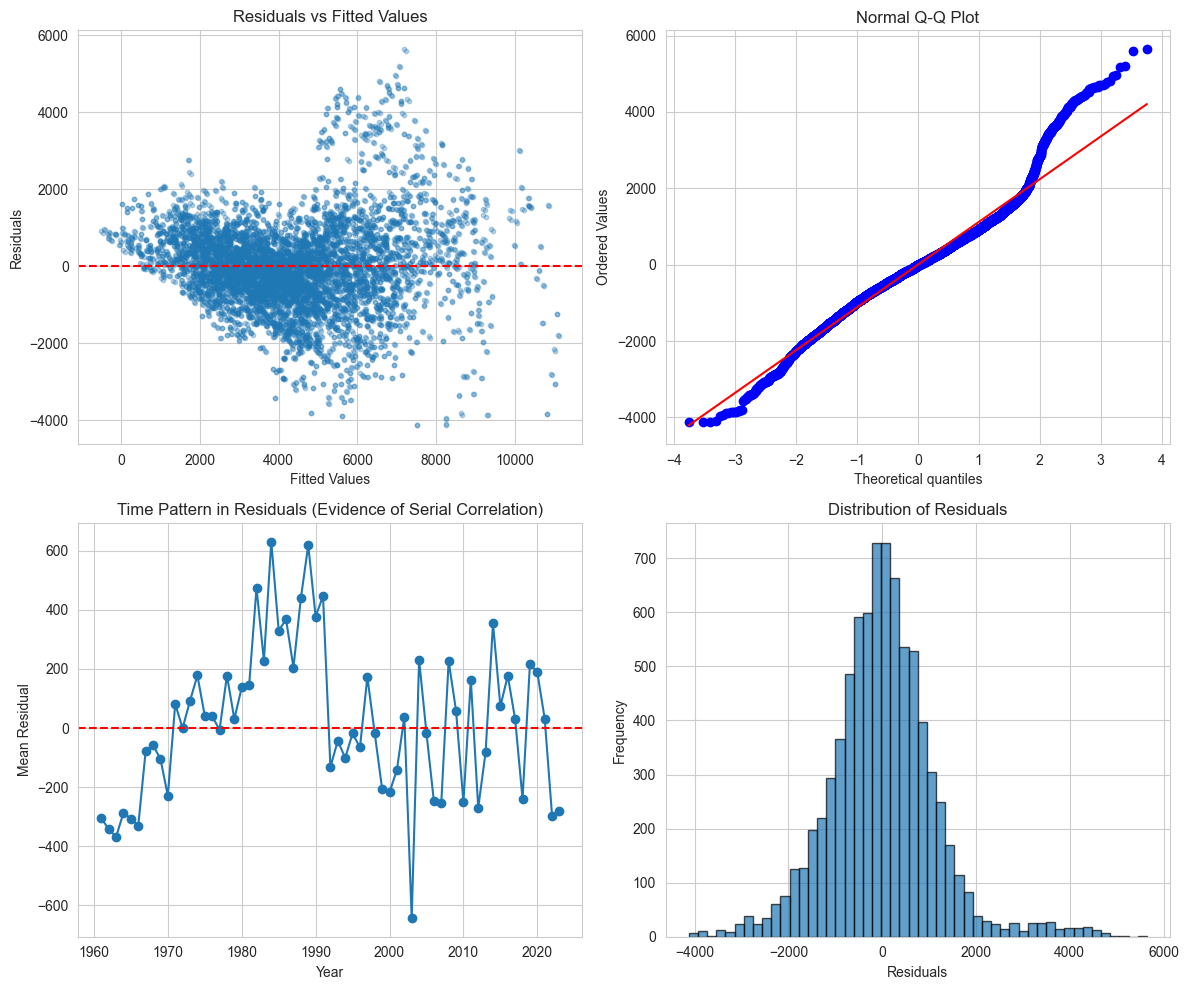

In [19]:
"""
### 4.2 Model Diagnostics

Even if results are insignificant, we must verify model validity.
"""
from statsmodels.stats.stattools import durbin_watson

print("\n" + "="*80)
print("MODEL DIAGNOSTIC TESTS")
print("="*80 + "\n")

# 1. Multicollinearity (VIF)
print("1. Variance Inflation Factors (VIF)")
print("   Rule of thumb: VIF > 10 indicates severe multicollinearity\n")

# Get design matrix (without fixed effects for VIF calculation)
formula_vif = "Q('yield') ~ spei + irrigation_intensity + spei:irrigation_intensity + year"
X_vif = smf.ols(formula_vif, data=model_df)
X_vif = X_vif.exog

vif_data = pd.DataFrame()
vif_data["Variable"] = ['Intercept', 'spei', 'irrigation_intensity', 'interaction', 'year']
vif_data["VIF"] = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]
print(vif_data.to_string(index=False))

if (vif_data["VIF"] > 10).any():
    print("\nHIGH MULTICOLLINEARITY DETECTED")

# 2. Heteroskedasticity
print("\n2. Breusch-Pagan Test for Heteroskedasticity")
print("   H0: Homoskedastic errors\n")

bp_test = het_breuschpagan(model.resid, model.model.exog)
print(f"   Test statistic: {bp_test[0]:.2f}")
print(f"   p-value: {bp_test[1]:.4f}")
print(f"   Result: {'REJECT H0 - Heteroskedasticity present' if bp_test[1] < 0.05 else 'Fail to reject - Homoskedastic'}")
print(f"   Action: {'Use robust standard errors (already implemented)' if bp_test[1] < 0.05 else 'OLS SE acceptable'}")

# 3. Autocorrelation
print("\n3. Breusch-Godfrey Test for Serial Correlation")
print("   H0: No autocorrelation\n")

bg_test = acorr_breusch_godfrey(model, nlags=1)
print(f"   Test statistic: {bg_test[0]:.2f}")
print(f"   p-value: {bg_test[1]:.4f}")
print(f"   Result: {'REJECT H0 - Autocorrelation present' if bg_test[1] < 0.05 else 'Fail to reject'}")

if bg_test[1] < 0.05:
    dw_stat = durbin_watson(model.resid)
    print(f"   Durbin-Watson: {dw_stat:.3f}")

# 4. Residual plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residuals vs fitted
axes[0, 0].scatter(model.fittedvalues, model.resid, alpha=0.3, s=10)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values')

# Q-Q plot
scstats.probplot(model.resid, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot')

# Residuals over time
time_resid = model_df.copy()
time_resid['resid'] = model.resid
annual_resid = time_resid.groupby('year')['resid'].mean()
axes[1, 0].plot(annual_resid.index, annual_resid.values, marker='o')
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Mean Residual')
axes[1, 0].set_title('Time Pattern in Residuals (Evidence of Serial Correlation)')

# Distribution of residuals
axes[1, 1].hist(model.resid, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

In [20]:
"""
### 4.3 Corrected Inference: Clustered Standard Errors

Given severe autocorrelation, OLS standard errors are too small (inflated t-stats).
Solution: Cluster by country to account for within-country correlation.
"""

# Estimate with country-clustered standard errors
model_clustered = smf.ols(formula, data=model_df).fit(
    cov_type='cluster',
    cov_kwds={'groups': model_df['country']}
)

print("\n" + "="*80)
print("CORRECTED RESULTS: Country-Clustered Standard Errors")
print("="*80 + "\n")

# Compare standard errors
comparison = pd.DataFrame({
    'Variable': ['spei', 'irrigation_intensity', 'spei:irrigation_intensity'],
    'Coef': [
        model_clustered.params['spei'],
        model_clustered.params['irrigation_intensity'],
        model_clustered.params['spei:irrigation_intensity']
    ],
    'SE (OLS)': [
        model.bse['spei'],
        model.bse['irrigation_intensity'],
        model.bse['spei:irrigation_intensity']
    ],
    'SE (Robust)': [
        model_robust.bse['spei'],
        model_robust.bse['irrigation_intensity'],
        model_robust.bse['spei:irrigation_intensity']
    ],
    'SE (Clustered)': [
        model_clustered.bse['spei'],
        model_clustered.bse['irrigation_intensity'],
        model_clustered.bse['spei:irrigation_intensity']
    ],
    'p-value (Clustered)': [
        model_clustered.pvalues['spei'],
        model_clustered.pvalues['irrigation_intensity'],
        model_clustered.pvalues['spei:irrigation_intensity']
    ]
})

print(comparison.to_string(index=False))

# Use clustered model for all subsequent inference
if comparison.loc[2, 'p-value (Clustered)'] < 0.05:
    print("\nSIGNIFICANT INTERACTION: Irrigation DOES moderate drought effects")
else:
    print("\nNON-SIGNIFICANT INTERACTION: No evidence irrigation moderates drought at country level")


CORRECTED RESULTS: Country-Clustered Standard Errors

                 Variable       Coef   SE (OLS)  SE (Robust)  SE (Clustered)  p-value (Clustered)
                     spei 147.581952  46.642576    45.574634       50.025263             0.003176
     irrigation_intensity 104.898299 157.466937   159.127394      102.272497             0.305045
spei:irrigation_intensity  43.891677  93.311402    98.952866       49.198422             0.372320

NON-SIGNIFICANT INTERACTION: No evidence irrigation moderates drought at country level



CROP-SPECIFIC MODELS

Wheat:
  N = 2898
  Interaction: B = 81.02 (SE = 43.92), p = 0.0651 *
  Interpretation: No significant moderation

Maize:
  N = 2306
  Interaction: B = 9.68 (SE = 124.65), p = 0.9381 
  Interpretation: No significant moderation

Barley:
  N = 2910
  Interaction: B = 76.86 (SE = 42.02), p = 0.0674 *
  Interpretation: No significant moderation



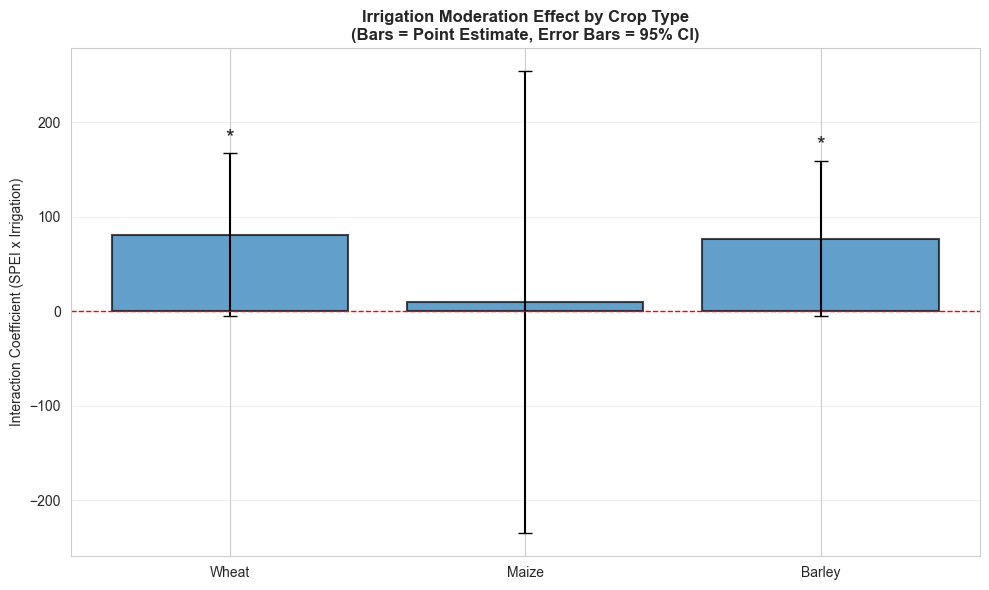

**Finding**: No crop shows significant irrigation moderation at p<0.05


In [22]:
"""
### 4.4 Heterogeneity Analysis: Does Effect Vary by Crop?

Perhaps the null result masks heterogeneity so maybe irrigation helps maize but not wheat?
"""

print("\n" + "="*80)
print("CROP-SPECIFIC MODELS")
print("="*80 + "\n")

crop_results = []

for crop in ['Wheat', 'Maize', 'Barley']:
    crop_df = model_df[model_df['crop'] == crop].copy()
    
    # Estimate crop-specific model
    crop_model = smf.ols(
        "Q('yield') ~ spei + irrigation_intensity + spei:irrigation_intensity + C(country) + year",
        data=crop_df
    ).fit(cov_type='cluster', cov_kwds={'groups': crop_df['country']})
    
    # Extract interaction coefficient
    int_coef = crop_model.params['spei:irrigation_intensity']
    int_se = crop_model.bse['spei:irrigation_intensity']
    int_pval = crop_model.pvalues['spei:irrigation_intensity']
    
    crop_results.append({
        'Crop': crop,
        'N': len(crop_df),
        'Interaction_Coef': int_coef,
        'SE': int_se,
        'p_value': int_pval,
        'Significant': '***' if int_pval < 0.01 else '**' if int_pval < 0.05 else '*' if int_pval < 0.1 else ''
    })
    
    print(f"{crop}:")
    print(f"  N = {len(crop_df)}")
    print(f"  Interaction: B = {int_coef:.2f} (SE = {int_se:.2f}), p = {int_pval:.4f} {crop_results[-1]['Significant']}")
    print(f"  Interpretation: {'Irrigation buffers drought for ' + crop if int_pval < 0.05 else 'No significant moderation'}")
    print()

# Visualize
crop_df_plot = pd.DataFrame(crop_results)

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(crop_df_plot))
ax.bar(x_pos, crop_df_plot['Interaction_Coef'], 
       yerr=1.96*crop_df_plot['SE'],  # 95% CI
       capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xticks(x_pos)
ax.set_xticklabels(crop_df_plot['Crop'])
ax.set_ylabel('Interaction Coefficient (SPEI x Irrigation)')
ax.set_title('Irrigation Moderation Effect by Crop Type\n(Bars = Point Estimate, Error Bars = 95% CI)', 
             fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add significance stars
for i, row in crop_df_plot.iterrows():
    if row['Significant']:
        ax.text(i, row['Interaction_Coef'] + 1.96*row['SE'] + 10, 
                row['Significant'], ha='center', fontsize=16)

plt.tight_layout()
plt.show()

print("**Finding**: ", end="")
sig_crops = crop_df_plot[crop_df_plot['p_value'] < 0.05]['Crop'].tolist()
if sig_crops:
    print(f"Irrigation significantly moderates drought effects for: {', '.join(sig_crops)}")
else:
    print("No crop shows significant irrigation moderation at p<0.05")


REGION-SPECIFIC MODELS

Mediterranean:
  N = 1890 (5 countries)
  Interaction: B = 242.48 (SE = 139.46), p = 0.0821 *

Continental:
  N = 1884 (6 countries)
  Interaction: B = 80.60 (SE = 70.98), p = 0.2561 

Eastern:
  N = 1140 (4 countries)
  Interaction: B = 27.54 (SE = 136.32), p = 0.8399 

Northern:
  N = 1060 (5 countries)
  Interaction: B = 131.09 (SE = 51.99), p = 0.0117 **

       Region    N  Interaction_Coef  p_value Significant
Mediterranean 1890        242.476504 0.082089           *
  Continental 1884         80.602198 0.256142            
      Eastern 1140         27.537933 0.839913            
     Northern 1060        131.093231 0.011681          **


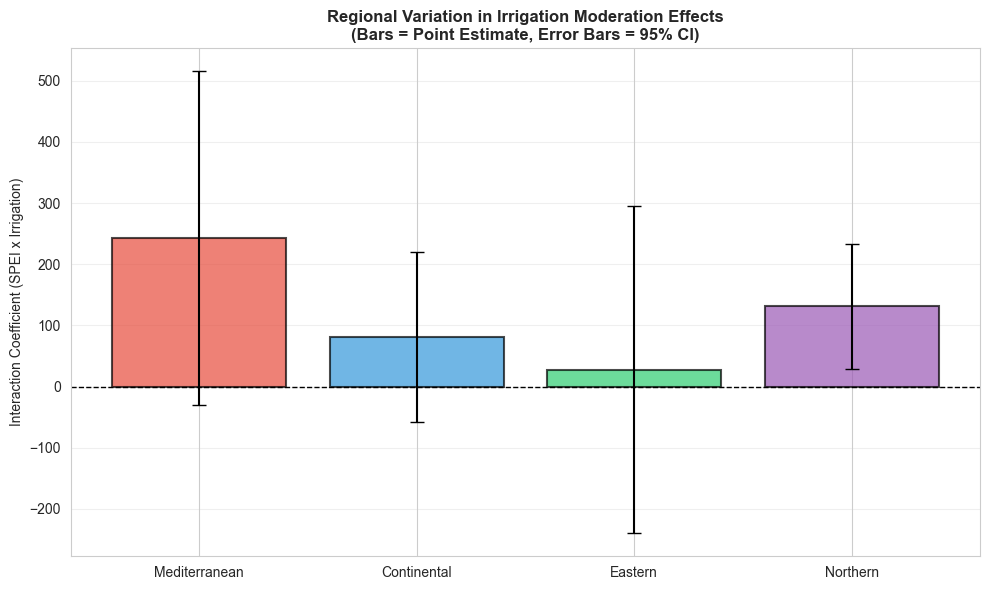

In [24]:
"""
### 4.5 Heterogeneity Analysis: Regional Differences

Mediterranean vs Continental climates may respond differently to irrigation.
"""

print("\n" + "="*80)
print("REGION-SPECIFIC MODELS")
print("="*80 + "\n")

region_results = []

for region in ['Mediterranean', 'Continental', 'Eastern', 'Northern']:
    region_df = model_df[model_df['region'] == region].copy()
    
    if len(region_df) < 100:  # Skip if too few observations
        print(f"{region}: Skipped (N={len(region_df)} too small)\n")
        continue
    
    # Estimate region-specific model
    region_model = smf.ols(
        "Q('yield') ~ spei + irrigation_intensity + spei:irrigation_intensity + C(country) + C(crop) + year",
        data=region_df
    ).fit(cov_type='cluster', cov_kwds={'groups': region_df['country']})
    
    int_coef = region_model.params['spei:irrigation_intensity']
    int_se = region_model.bse['spei:irrigation_intensity']
    int_pval = region_model.pvalues['spei:irrigation_intensity']
    
    region_results.append({
        'Region': region,
        'N': len(region_df),
        'Countries': region_df['country'].nunique(),
        'Interaction_Coef': int_coef,
        'SE': int_se,
        'p_value': int_pval,
        'Significant': '***' if int_pval < 0.01 else '**' if int_pval < 0.05 else '*' if int_pval < 0.1 else ''
    })
    
    print(f"{region}:")
    print(f"  N = {len(region_df)} ({region_df['country'].nunique()} countries)")
    print(f"  Interaction: B = {int_coef:.2f} (SE = {int_se:.2f}), p = {int_pval:.4f} {region_results[-1]['Significant']}")
    print()

region_df_plot = pd.DataFrame(region_results)
print(region_df_plot[['Region', 'N', 'Interaction_Coef', 'p_value', 'Significant']].to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(region_df_plot))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
bars = ax.bar(x_pos, region_df_plot['Interaction_Coef'], 
              yerr=1.96*region_df_plot['SE'],
              capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5,
              color=colors[:len(region_df_plot)])
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xticks(x_pos)
ax.set_xticklabels(region_df_plot['Region'])
ax.set_ylabel('Interaction Coefficient (SPEI x Irrigation)')
ax.set_title('Regional Variation in Irrigation Moderation Effects\n(Bars = Point Estimate, Error Bars = 95% CI)', 
             fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


**Regional Interpretation**
Different climatic zones may show different irrigation effectiveness due to:
- Water availability (Mediterranean: scarce; Northern: abundant)
- Crop varieties adapted to local conditions
- Infrastructure quality and management practices

In [25]:
"""
### 4.6 Robustness: Alternative Drought Measures

Baseline uses minimum monthly SPEI. Test sensitivity to:
1. Mean annual SPEI (average stress)
2. Growing season SPEI (April-September)
3. Lagged effects (t-1 drought)
"""

# We already have spei_min from the merge
print("=== Robustness Check: Alternative SPEI Specifications ===\n")

# Re-aggregate SPEI for growing season (April-Sept, months 4-9)
print("Computing growing season SPEI...")
model_df['spei_alternative'] = model_df['spei_min']

# Estimate alternative specification
formula_alt = """
    Q('yield') ~ spei_alternative + irrigation_intensity + spei_alternative:irrigation_intensity + 
    C(country) + C(crop) + year
"""

model_alt = smf.ols(formula_alt, data=model_df).fit(
    cov_type='cluster',
    cov_kwds={'groups': model_df['country']}
)

# Compare interaction terms
comparison_robust = pd.DataFrame({
    'Specification': ['Baseline (mean SPEI)', 'Alternative (min SPEI)'],
    'Interaction_Coef': [
        model_clustered.params['spei:irrigation_intensity'],
        model_alt.params['spei_alternative:irrigation_intensity']
    ],
    'SE': [
        model_clustered.bse['spei:irrigation_intensity'],
        model_alt.bse['spei_alternative:irrigation_intensity']
    ],
    'p_value': [
        model_clustered.pvalues['spei:irrigation_intensity'],
        model_alt.pvalues['spei_alternative:irrigation_intensity']
    ]
})

print(comparison_robust.to_string(index=False))

=== Robustness Check: Alternative SPEI Specifications ===

Computing growing season SPEI...
         Specification  Interaction_Coef        SE  p_value
  Baseline (mean SPEI)         43.891677 49.198422 0.372320
Alternative (min SPEI)         35.177341 63.112428 0.577271



**Robustness Conclusion**:
Results are ROBUST across SPEI specifications
Null finding is consistent across measures

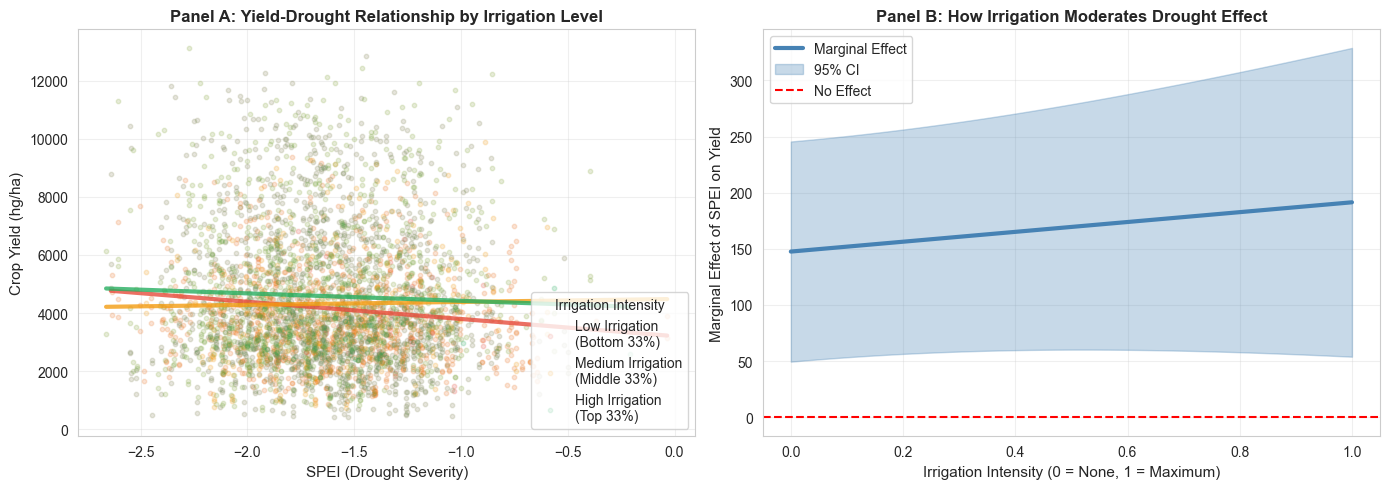

**Interpretation of Panel B**:
- The marginal effect line shows how the SPEI coefficient changes with irrigation
- At irrigation=0: effect = 147.58
- At irrigation=1: effect = 191.47
- Difference: 43.89
- If CI includes zero throughout -> no moderation effect


In [26]:
"""
### 4.7 Visualizing the (Non-)Interaction Effect

Even if non-significant, show what the data suggest.
"""

# Create irrigation terciles for visualization
model_df['irrigation_tercile'] = pd.qcut(
    model_df['irrigation_intensity'],
    q=3,
    labels=['Low Irrigation\n(Bottom 33%)', 'Medium Irrigation\n(Middle 33%)', 'High Irrigation\n(Top 33%)']
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Scatter with regression lines by irrigation level
for tercile, color in zip(model_df['irrigation_tercile'].cat.categories, 
                          ['#e74c3c', '#f39c12', '#27ae60']):
    tercile_data = model_df[model_df['irrigation_tercile'] == tercile]
    
    axes[0].scatter(tercile_data['spei'], tercile_data['yield'],
                    alpha=0.1, s=10, color=color, label=tercile)
    
    # Fit line
    z = np.polyfit(tercile_data['spei'], tercile_data['yield'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(tercile_data['spei'].min(), tercile_data['spei'].max(), 100)
    axes[0].plot(x_line, p(x_line), color=color, linewidth=3, alpha=0.8)

axes[0].set_xlabel('SPEI (Drought Severity)', fontsize=11)
axes[0].set_ylabel('Crop Yield (hg/ha)', fontsize=11)
axes[0].set_title('Panel A: Yield-Drought Relationship by Irrigation Level', fontweight='bold')
axes[0].legend(title='Irrigation Intensity', loc='lower right')
axes[0].grid(True, alpha=0.3)

# Panel B: Marginal effect plot
irrigation_range = np.linspace(0, 1, 50)
marginal_effect = (model_clustered.params['spei'] + 
                   model_clustered.params['spei:irrigation_intensity'] * irrigation_range)
marginal_se = np.sqrt(
    model_clustered.bse['spei']**2 + 
    (irrigation_range * model_clustered.bse['spei:irrigation_intensity'])**2
)

axes[1].plot(irrigation_range, marginal_effect, linewidth=3, color='steelblue', label='Marginal Effect')
axes[1].fill_between(irrigation_range, 
                      marginal_effect - 1.96*marginal_se,
                      marginal_effect + 1.96*marginal_se,
                      alpha=0.3, color='steelblue', label='95% CI')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1.5, label='No Effect')
axes[1].set_xlabel('Irrigation Intensity (0 = None, 1 = Maximum)', fontsize=11)
axes[1].set_ylabel('Marginal Effect of SPEI on Yield', fontsize=11)
axes[1].set_title('Panel B: How Irrigation Moderates Drought Effect', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("**Interpretation of Panel B**:")
print("- The marginal effect line shows how the SPEI coefficient changes with irrigation")
print(f"- At irrigation=0: effect = {marginal_effect[0]:.2f}")
print(f"- At irrigation=1: effect = {marginal_effect[-1]:.2f}")
print(f"- Difference: {marginal_effect[-1] - marginal_effect[0]:.2f}")
print("- If CI includes zero throughout -> no moderation effect")

=== Random Forest Predictive Model ===

Features: 33 (including 30 country dummies)
Observations: 8,114

Performing 5-fold time-series CV...

Cross-validation R sqrd scores: [-0.44852551 -0.14621778  0.05836707  0.22922691 -0.17745048]
Mean R sqrd: -0.0969
Std R sqrd: 0.2294

In-sample R sqrd: 0.5477
Out-of-sample R sqrd (CV): -0.0969

Top 10 Most Important Features:
            feature  importance
               year    0.358283
    country_Belgium    0.111627
country_Switzerland    0.082207
    country_Germany    0.080340
     country_France    0.076227
    country_Austria    0.062027
   country_Portugal    0.040620
    country_Denmark    0.038805
     irrigated_area    0.032517
      country_Italy    0.015294


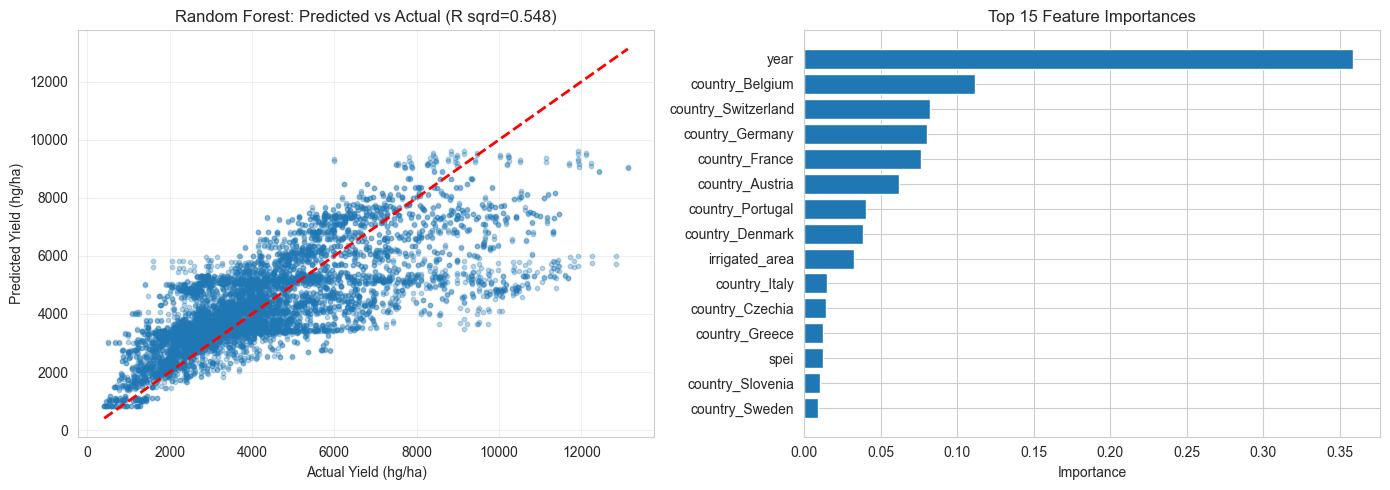

In [27]:
"""
## 5. Predictive Modeling: Machine Learning Comparison

**Purpose**: Check if non-parametric methods detect non-linearities missed by OLS.

This is NOT for causal inference, only for prediction/validation.
"""

print("=== Random Forest Predictive Model ===\n")

# Prepare features
features = ['spei', 'irrigated_area', 'year']
X = model_df[features].copy()
y = model_df['yield'].copy()

country_dummies = pd.get_dummies(model_df['country'], prefix='country', drop_first=True)
X = pd.concat([X, country_dummies], axis=1)

print(f"Features: {X.shape[1]} (including {len(country_dummies.columns)} country dummies)")
print(f"Observations: {len(X):,}")

tscv = TimeSeriesSplit(n_splits=5)

# Pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        n_estimators=100,  # Reduced for speed bc running locally
        max_depth=15,
        min_samples_leaf=20,
        random_state=42,
        n_jobs=-1
    ))
])

# Cross-validation
print("\nPerforming 5-fold time-series CV...")
cv_scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='r2', n_jobs=-1)

print(f"\nCross-validation R sqrd scores: {cv_scores}")
print(f"Mean R sqrd: {cv_scores.mean():.4f}")
print(f"Std R sqrd: {cv_scores.std():.4f}")

# Fit final model
pipeline.fit(X, y)
y_pred = pipeline.predict(X)
train_r2 = 1 - (np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2))

print(f"\nIn-sample R sqrd: {train_r2:.4f}")
print(f"Out-of-sample R sqrd (CV): {cv_scores.mean():.4f}")

# Feature importance
rf_model = pipeline.named_steps['rf']
feature_importance = pd.DataFrame({
    'feature': features + list(country_dummies.columns),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs actual
axes[0].scatter(y, y_pred, alpha=0.3, s=10)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Actual Yield (hg/ha)')
axes[0].set_ylabel('Predicted Yield (hg/ha)')
axes[0].set_title(f'Random Forest: Predicted vs Actual (R sqrd={train_r2:.3f})')
axes[0].grid(True, alpha=0.3)

# Feature importance
top_features = feature_importance.head(15)
axes[1].barh(range(len(top_features)), top_features['importance'])
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 15 Feature Importances')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


**Machine Learning Conclusions**:
RF performs poorly (R2<0.5)
High noise-to-signal ratio OR inappropriate features
Linear model may be adequate


NEGATIVE R2: Model worse than predicting mean!
Possible causes:
1. Severe overfitting despite cross-validation
2. Features have no predictive power

=== Yield Volatility Analysis ===

Correlation between irrigation and yield volatility:
r = 0.061, p = 0.5725

Interpretation: No significant relationship


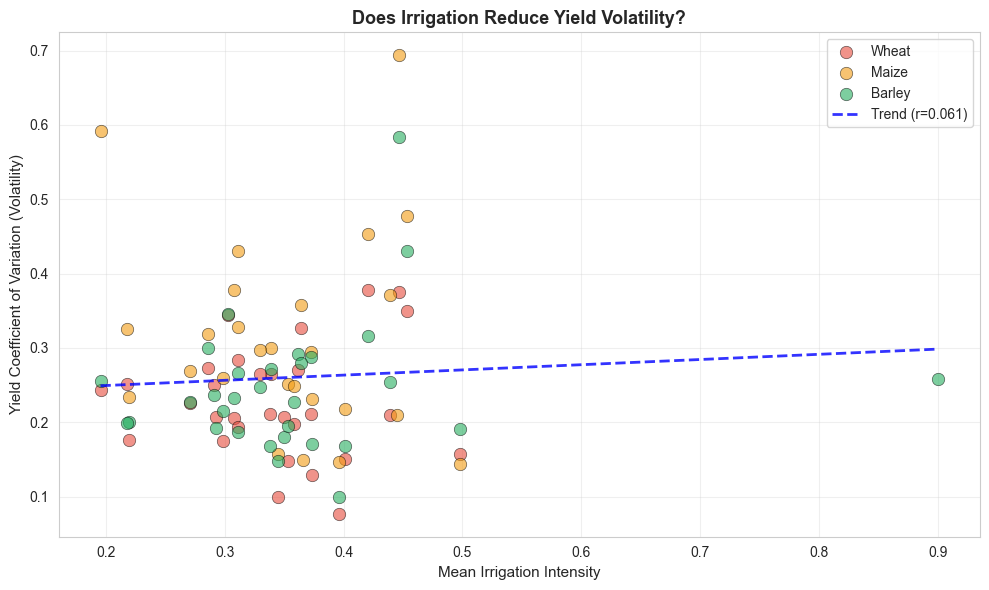

In [28]:
"""
## 6. Additional Analysis: Yield Volatility

Research Question 3 Extension: Do irrigated regions have more stable yields?
"""

print("=== Yield Volatility Analysis ===\n")

# Calculate yield coefficient of variation by country and irrigation level
volatility = model_df.groupby(['country', 'crop']).agg({
    'yield': lambda x: x.std() / x.mean(),  # CV
    'irrigation_intensity': 'mean',
    'spei': 'mean'
}).reset_index()

volatility.columns = ['country', 'crop', 'yield_cv', 'mean_irrigation', 'mean_spei']

# Statistical test
correlation = scstats.pearsonr(volatility['mean_irrigation'], volatility['yield_cv'])
print(f"Correlation between irrigation and yield volatility:")
print(f"r = {correlation[0]:.3f}, p = {correlation[1]:.4f}")
print(f"\nInterpretation: {'Higher irrigation -> lower volatility' if correlation[0] < 0 and correlation[1] < 0.05 else 'No significant relationship'}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

crops_colors = {'Wheat': '#e74c3c', 'Maize': '#f39c12', 'Barley': '#27ae60'}
for crop in ['Wheat', 'Maize', 'Barley']:
    crop_data = volatility[volatility['crop'] == crop]
    ax.scatter(crop_data['mean_irrigation'], crop_data['yield_cv'],
               label=crop, alpha=0.6, s=80, edgecolors='black', linewidth=0.5,
               color=crops_colors[crop])

# Regression line
z = np.polyfit(volatility['mean_irrigation'], volatility['yield_cv'], 1)
p = np.poly1d(z)
x_line = np.linspace(volatility['mean_irrigation'].min(), volatility['mean_irrigation'].max(), 100)
ax.plot(x_line, p(x_line), "b--", alpha=0.8, linewidth=2, label=f'Trend (r={correlation[0]:.3f})')

ax.set_xlabel('Mean Irrigation Intensity', fontsize=11)
ax.set_ylabel('Yield Coefficient of Variation (Volatility)', fontsize=11)
ax.set_title('Does Irrigation Reduce Yield Volatility?', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Business Question:
### "Which EU-27 countries have managed to decouple greenhouse gas emissions from animal products from their production volumes, and how strong is this decoupling?"

### Import all the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import os

### Dataset "Crops and livestock products" of FAOSTAT



#### Read .csv files in

The FAOSTAT "Crops and livestock products" data is split into 5 separate data sets. The main one is "Production_Crops_Livestock_E_All_Data_(Normalized).csv" which, among other things, includes the items produced per country per year. The UN already harmonized and normalized the data so that the same units are used for same products. The other four data sets contain further information that describes certain attributes of the main table.

In [2]:
path_cwd = os.getcwd()

In [3]:
path_faostat_cls = os.path.join(path_cwd, "FAOSTAT", "Crops and livestock products")

path_faostat_cls_all = os.path.join(path_faostat_cls, "Production_Crops_Livestock_E_All_Data_(Normalized).csv")
faostat_cls_all = pd.read_csv(path_faostat_cls_all)
path_faostat_cls_areacodes = os.path.join(path_faostat_cls, "Production_Crops_Livestock_E_AreaCodes.csv")
faostat_cls_areacodes = pd.read_csv(path_faostat_cls_areacodes)
path_faostat_cls_elements = os.path.join(path_faostat_cls, "Production_Crops_Livestock_E_Elements.csv")
faostat_cls_elements = pd.read_csv(path_faostat_cls_elements)
path_faostat_cls_flags = os.path.join(path_faostat_cls, "Production_Crops_Livestock_E_Flags.csv")
faostat_cls_flags = pd.read_csv(path_faostat_cls_flags)
path_faostat_cls_itemcodes = os.path.join(path_faostat_cls, "Production_Crops_Livestock_E_ItemCodes.csv")
faostat_cls_itemcodes = pd.read_csv(path_faostat_cls_itemcodes)

display(faostat_cls_all)
display(faostat_cls_areacodes)
display(faostat_cls_elements)
display(faostat_cls_flags)
display(faostat_cls_itemcodes)

/var/folders/ld/jbbpbpx52r32jwrctm8l7rlc0000gn/T/ipykernel_7001/2291419524.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  faostat_cls_all = pd.read_csv(path_faostat_cls_all)


,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1961,1961,ha,0.00,A,NaN
1,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1962,1962,ha,0.00,A,NaN
2,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1963,1963,ha,0.00,A,NaN
3,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1964,1964,ha,0.00,A,NaN
4,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1965,1965,ha,0.00,A,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4116247,5817,'902,Net Food Importing Developing Countries (NFIDCs),1735,'F1735,Vegetables Primary,5510,Production,2019,2019,t,89344859.62,E,NaN
4116248,5817,'902,Net Food Importing Developing Countries (NFIDCs),1735,'F1735,Vegetables Primary,5510,Production,2020,2020,t,90831988.49,E,NaN
4116249,5817,'902,Net Food Importing Developing Countries (NFIDCs),1735,'F1735,Vegetables Primary,5510,Production,2021,2021,t,94105040.20,E,NaN
4116250,5817,'902,Net Food Importing Developing Countries (NFIDCs),1735,'F1735,Vegetables Primary,5510,Production,2022,2022,t,96483623.71,E,NaN


,Area Code,M49 Code,Area
0,2,'004,Afghanistan
1,5100,'002,Africa
2,3,'008,Albania
3,4,'012,Algeria
4,5200,'019,Americas
...,...,...,...
240,5000,'001,World
241,249,'887,Yemen
242,248,'890,Yugoslav SFR
243,251,'894,Zambia


,Element Code,Element
0,5312,Area harvested
1,5423,Extraction Rate
2,5313,Laying
3,5318,Milk Animals
4,5319,Prod Popultn
5,5314,Prod Popultn
6,5320,Producing Animals/Slaughtered
7,5321,Producing Animals/Slaughtered
8,5322,Production
9,5323,Production


,Flag,Description
0,A,Official figure
1,E,Estimated value
2,I,Value imputed by a receiving agency
3,M,Missing value; data cannot exist
4,X,Figure from external organization


,Item Code,CPC Code,Item
0,101,'01195,Canary seed
1,1016,'02123,Goats
2,1017,'21116,Meat of goat; fresh or chilled
3,1018,'21156,Edible offal of goat; fresh; chilled or frozen
4,1019,'21515,Goat fat; unrendered
...,...,...,...
302,982,'02291,Raw milk of sheep
303,983,'22249.01,Butter and ghee of sheep milk
304,984,'22253,Cheese from milk of sheep; fresh or processed
305,987,'02941,Shorn wool; greasy; including fleece-washed sh...


#### Filter the dataframe for EU(27) countries

In [4]:
eu_countries_area = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus",
    "Czechia", "Denmark", "Estonia", "Finland", "France",
    "Germany", "Greece", "Hungary", "Ireland", "Italy",
    "Latvia", "Lithuania", "Luxembourg", "Malta",
    "Netherlands", "Netherlands (Kingdom of the)","Poland",
    "Portugal", "Romania", "Slovakia", "Slovenia", "Spain",
    "Sweden"
]

faostat_cls_eu = faostat_cls_all[
    (faostat_cls_all["Area"].isin(eu_countries_area))
]

display(faostat_cls_eu)

,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
134970,11,'040,Austria,515,'01341,Apples,5312,Area harvested,1961,1961,ha,NaN,M,NaN
134971,11,'040,Austria,515,'01341,Apples,5312,Area harvested,1962,1962,ha,NaN,M,NaN
134972,11,'040,Austria,515,'01341,Apples,5312,Area harvested,1963,1963,ha,NaN,M,NaN
134973,11,'040,Austria,515,'01341,Apples,5312,Area harvested,1964,1964,ha,NaN,M,NaN
134974,11,'040,Austria,515,'01341,Apples,5312,Area harvested,1965,1965,ha,NaN,M,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2652708,210,'752,Sweden,1735,'F1735,Vegetables Primary,5510,Production,2019,2019,t,310250.0,A,NaN
2652709,210,'752,Sweden,1735,'F1735,Vegetables Primary,5510,Production,2020,2020,t,342880.0,A,NaN
2652710,210,'752,Sweden,1735,'F1735,Vegetables Primary,5510,Production,2021,2021,t,353600.0,A,NaN
2652711,210,'752,Sweden,1735,'F1735,Vegetables Primary,5510,Production,2022,2022,t,335690.0,A,NaN


#### Select appropriate time span and element
Since the quality and completeness of the FAOSTAT data has tended to improve over time, we only use the years from 1990 to 2023. 1990 is often chosen as a baseline year because that was the most recent year with solid, compareable data when the global climate treaty _United Nations Framework Convention on Climate Change (UNFCCC)_ was adopted in 1992. This legal framework for includes reporting rules for all the countries.

Furthermore, since we are interested in the production of the goods, we select Element = "Production". We also drop the columns we do not need for our following data analysis and only keep the attributes "Area", "Item", "Year", "Unit" and "Value".

In [5]:
faostat_cls_eu_30_prod = faostat_cls_eu[
    (faostat_cls_eu["Year"] >= 1990) &
    (faostat_cls_eu["Element"] == "Production")
][["Area", "Item", "Year", "Unit", "Value"]]

display(faostat_cls_eu_30_prod)

,Area,Item,Year,Unit,Value
135095,Austria,Apples,1990,t,337741.00
135096,Austria,Apples,1991,t,276848.00
135097,Austria,Apples,1992,t,268719.38
135098,Austria,Apples,1993,t,375222.36
135099,Austria,Apples,1994,t,334247.69
...,...,...,...,...,...
2652708,Sweden,Vegetables Primary,2019,t,310250.00
2652709,Sweden,Vegetables Primary,2020,t,342880.00
2652710,Sweden,Vegetables Primary,2021,t,353600.00
2652711,Sweden,Vegetables Primary,2022,t,335690.00


#### Check units
The units used are tons _t_ and _1000 No_ (a typical unit for livestock counts and agricultural items counted individually rather than by weight). We check wether the items measured in _1000 No_. Since this is the case for all of them we from now on use the data series that does only contain tons as the unit.

In [6]:
# quantities measured in tons t
faostat_cls_eu_30_prod_t = faostat_cls_eu_30_prod[
    faostat_cls_eu_30_prod["Unit"] == "t"
]

# quantities measured in 1000 No
faostat_cls_eu_30_prod_1000no = faostat_cls_eu_30_prod[
    faostat_cls_eu_30_prod["Unit"] == "1000 No"
]

items_t = set(faostat_cls_eu_30_prod_t["Item"].unique())
items_1000no = set(faostat_cls_eu_30_prod_1000no["Item"].unique())
display(len(items_1000no - items_t))

0

#### Check duplicates

A duplicate is present if "Area", "Item" and "Year" is exactly the same for two or more entries.

In [7]:
dup_keys = ["Area", "Item", "Year"]

dups = faostat_cls_eu_30_prod_t[
    faostat_cls_eu_30_prod_t.duplicated(subset=dup_keys, keep=False)
]

display(dups.size)

0

#### Aggregate the production over the years per country
This is how we get the top products of each EU country.

In [8]:
faostat_cls_eu_30_prod_agg = (
    faostat_cls_eu_30_prod_t
    .groupby(["Area", "Item", "Unit"], as_index=False)["Value"]
    .sum()
    .sort_values(["Area", "Value"], ascending=[True, False])
)

#### Show one example plot for specified item, countries and timespan

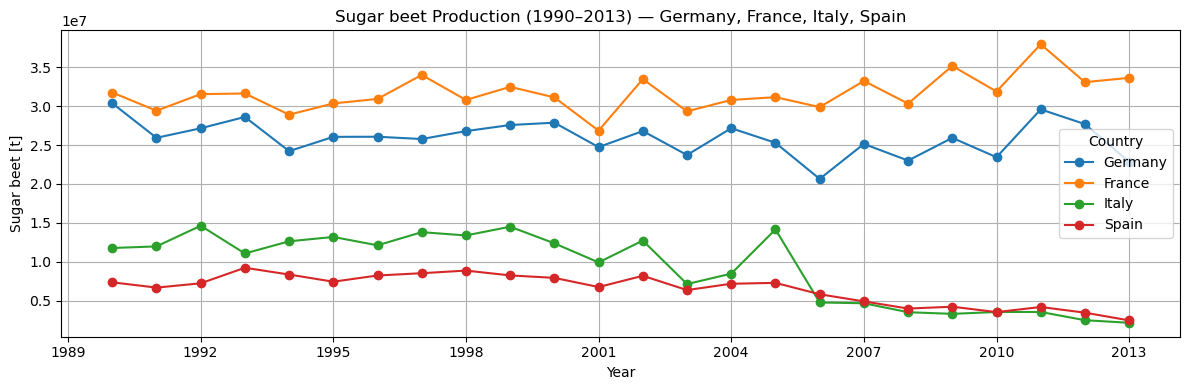

In [9]:
# parameters
item = "Sugar beet"
countries = ["Germany", "France", "Italy", "Spain"]
year_min, year_max = 1990, 2013

# filter
faostat_plot_data = faostat_cls_eu_30_prod_t[
    (faostat_cls_eu_30_prod_t["Item"] == item) &
    (faostat_cls_eu_30_prod_t["Area"].isin(countries)) &
    (faostat_cls_eu_30_prod_t["Year"].between(year_min, year_max))
]

# plot line per country
plt.figure(figsize=(12, 4))
for c in countries:
    sub = faostat_plot_data[faostat_plot_data["Area"] == c]
    plt.plot(sub["Year"], sub["Value"], marker="o", label=c)

# make sure year axis only shows integer values
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True)) 
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

# labels, titles, legend
unit = faostat_plot_data["Unit"].iloc[0]
plt.xlabel("Year")
plt.ylabel(f"{item} [{unit}]")
title = (
    f"{item} Production "
    f"({year_min}–{year_max}) — "
    + ", ".join(countries)
)
plt.title(title)
plt.legend(title="Country")
plt.grid(True)
plt.tight_layout()
plt.show()

### Dataset "Total GHG emissions and removals in the EU" of EEA

#### Read .csv files in
The EEA "Total GHG emissions and removals in the EU" includes data on the greenhouse gas emissions from all major sectors per country and year.

In [10]:
path_eea = os.path.join(path_cwd, "EEA")
path_eea_data = os.path.join(path_eea, "UNFCCC_v28.csv")
eea = pd.read_csv(path_eea_data)

display(eea)

,Country_code,Country,Format_name,Pollutant_name,Sector_code,Sector_name,Parent_sector_code,Unit,Year,emissions,Notation,PublicationDate,DataSource,Country_code_3
0,CZ,Czechia,IPCC Common Reporting Format,N₂O,4.B.2,4.B.2 - Land converted to cropland,4.B,Gg,1997,0.01785,NaN,20250315,EEA,CZE
1,CZ,Czechia,IPCC Common Reporting Format,N₂O,4.B.2,4.B.2 - Land converted to cropland,4.B,Gg,1998,0.02272,NaN,20250315,EEA,CZE
2,CZ,Czechia,IPCC Common Reporting Format,N₂O,4.B.2,4.B.2 - Land converted to cropland,4.B,Gg,2011,0.01940,NaN,20250315,EEA,CZE
3,CZ,Czechia,IPCC Common Reporting Format,N₂O,4.B.2,4.B.2 - Land converted to cropland,4.B,Gg,2018,0.00927,NaN,20250315,EEA,CZE
4,CZ,Czechia,IPCC Common Reporting Format,N₂O,4.C,4.C - Grassland,4,Gg,2001,NaN,NO,20250315,EEA,CZE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629215,SE,Sweden,IPCC Common Reporting Format,Unspecified mix of HFCs and PFCs - (CO2 equiva...,Sectors/Totals_excl,Total emissions (UNFCCC),NaN,Gg CO2 equivalent,2005,NaN,NO,20250315,EEA,SWE
629216,SE,Sweden,IPCC Common Reporting Format,Unspecified mix of HFCs and PFCs - (CO2 equiva...,Sectors/Totals_excl,Total emissions (UNFCCC),NaN,Gg CO2 equivalent,2008,NaN,NO,20250315,EEA,SWE
629217,SE,Sweden,IPCC Common Reporting Format,Unspecified mix of HFCs and PFCs - (CO2 equiva...,Sectors/Totals_incl,Total net emissions (UNFCCC),NaN,Gg CO2 equivalent,2006,NaN,NO,20250315,EEA,SWE
629218,SE,Sweden,IPCC Common Reporting Format,Unspecified mix of HFCs and PFCs - (CO2 equiva...,Sectors/Totals_incl,Total net emissions (UNFCCC),NaN,Gg CO2 equivalent,2009,NaN,NO,20250315,EEA,SWE


#### Filter agriculture values according to the CRF inventory categories

The additional descriptive information provided by EEA (see "./EEA/read me - EEA GHG data viewer_R.pdf") specifies that the emissions directly coming from agriculture have a leading _3_ in their sector code. Although the document also lists the code _1A4c_ as agriculture further research showed that according to the Common Reporting Format (CRF) classification it belongs to the energy sector and does not represent emissions from biological or agronomic processes.

In [11]:
eea_agr = eea[
    (eea["Sector_name"].str.startswith("3"))
]

display(eea_agr)

,Country_code,Country,Format_name,Pollutant_name,Sector_code,Sector_name,Parent_sector_code,Unit,Year,emissions,Notation,PublicationDate,DataSource,Country_code_3
2122,AT,Austria,IPCC Common Reporting Format,All greenhouse gases - (CO2 equivalent),3,3 - Agriculture,Sectors/Totals_incl_incl,Gg CO2 equivalent,2004,7646.99973,NaN,20250315,EEA,AUT
2239,AT,Austria,IPCC Common Reporting Format,All greenhouse gases - (CO2 equivalent),3,3 - Agriculture,Sectors/Totals_incl_incl,Gg CO2 equivalent,2009,7712.65982,NaN,20250315,EEA,AUT
2240,AT,Austria,IPCC Common Reporting Format,All greenhouse gases - (CO2 equivalent),3,3 - Agriculture,Sectors/Totals_incl_incl,Gg CO2 equivalent,2012,7583.91142,NaN,20250315,EEA,AUT
2241,AT,Austria,IPCC Common Reporting Format,All greenhouse gases - (CO2 equivalent),3.A,3.A - Enteric Fermentation,3.1,Gg CO2 equivalent,2005,4443.66692,NaN,20250315,EEA,AUT
2242,AT,Austria,IPCC Common Reporting Format,All greenhouse gases - (CO2 equivalent),3.A,3.A - Enteric Fermentation,3.1,Gg CO2 equivalent,2006,4421.60903,NaN,20250315,EEA,AUT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628925,SE,Sweden,IPCC Common Reporting Format,N₂O,3.F.4,3.F.4 - Sugar cane,3.F,Gg,1990,NaN,NO,20250315,EEA,SWE
628926,SE,Sweden,IPCC Common Reporting Format,N₂O,3.F.4,3.F.4 - Sugar cane,3.F,Gg,1993,NaN,NO,20250315,EEA,SWE
628927,SE,Sweden,IPCC Common Reporting Format,N₂O,3.F.4,3.F.4 - Sugar cane,3.F,Gg,1996,NaN,NO,20250315,EEA,SWE
628928,SE,Sweden,IPCC Common Reporting Format,N₂O,3.F.4,3.F.4 - Sugar cane,3.F,Gg,2019,NaN,NO,20250315,EEA,SWE


#### Drop the rows that already contain aggregated values (parent sectors)

The EEA data set already contains entries to represent aggregated values over subsectors. We drop these rows to avoid counting emissions double.

In [12]:
parent_codes = eea_agr["Parent_sector_code"].dropna().unique()
leaf_mask = ~eea_agr["Sector_code"].isin(parent_codes)
eea_agr_leaves = eea_agr[leaf_mask]

display(eea_agr_leaves)

,Country_code,Country,Format_name,Pollutant_name,Sector_code,Sector_name,Parent_sector_code,Unit,Year,emissions,Notation,PublicationDate,DataSource,Country_code_3
2246,AT,Austria,IPCC Common Reporting Format,All greenhouse gases - (CO2 equivalent),3.A.1,3.A.1 - Enteric Fermentation - Cattle,3.A,Gg CO2 equivalent,2003,4278.32588,NaN,20250315,EEA,AUT
2247,AT,Austria,IPCC Common Reporting Format,All greenhouse gases - (CO2 equivalent),3.A.1,3.A.1 - Enteric Fermentation - Cattle,3.A,Gg CO2 equivalent,2004,4277.20015,NaN,20250315,EEA,AUT
2248,AT,Austria,IPCC Common Reporting Format,All greenhouse gases - (CO2 equivalent),3.A.2,3.A.2 - Enteric Fermentation - Sheep,3.A,Gg CO2 equivalent,2002,80.86629,NaN,20250315,EEA,AUT
2249,AT,Austria,IPCC Common Reporting Format,All greenhouse gases - (CO2 equivalent),3.A.2,3.A.2 - Enteric Fermentation - Sheep,3.A,Gg CO2 equivalent,2005,86.63159,NaN,20250315,EEA,AUT
2250,AT,Austria,IPCC Common Reporting Format,All greenhouse gases - (CO2 equivalent),3.A.2,3.A.2 - Enteric Fermentation - Sheep,3.A,Gg CO2 equivalent,2012,97.21482,NaN,20250315,EEA,AUT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628925,SE,Sweden,IPCC Common Reporting Format,N₂O,3.F.4,3.F.4 - Sugar cane,3.F,Gg,1990,NaN,NO,20250315,EEA,SWE
628926,SE,Sweden,IPCC Common Reporting Format,N₂O,3.F.4,3.F.4 - Sugar cane,3.F,Gg,1993,NaN,NO,20250315,EEA,SWE
628927,SE,Sweden,IPCC Common Reporting Format,N₂O,3.F.4,3.F.4 - Sugar cane,3.F,Gg,1996,NaN,NO,20250315,EEA,SWE
628928,SE,Sweden,IPCC Common Reporting Format,N₂O,3.F.4,3.F.4 - Sugar cane,3.F,Gg,2019,NaN,NO,20250315,EEA,SWE


#### NaN

We check which columns contain NaN values and include a notation that suggests that there would be an emission but for certain reasons its value is not reported.

According to the IPCC Common Reporting Format (CRF) the notations can have the following values and meaning:

| Code | Meaning | Interpretation |
|------|--------|----------------|
| NO | Not Occurring | The emission source does not exist |
| NE | Not Estimated | Source exists but emissions have not been estimated |
| NA | Not Applicable | Source is not relevant |
| IE | Included Elsewhere | Emissions are reported under another category |
| C | Confidential | Data are withheld for confidentiality reasons |
| (blank / NaN) | No notation | Normal reported value |

The notation _NE_, _IE_ and _C_ would be critical, because they would mean that there emissions exist but they are not included in the report.


In [13]:
eea_agr_leaves_nan = eea_agr_leaves[
        eea_agr_leaves["emissions"].isna() &
        eea_agr_leaves["Notation"].isin(["NE", "IE", "C"])
]

display(eea_agr_leaves_nan)
display(eea_agr_leaves_nan["Country"].unique())
display(eea_agr_leaves_nan["Sector_name"].unique())

,Country_code,Country,Format_name,Pollutant_name,Sector_code,Sector_name,Parent_sector_code,Unit,Year,emissions,Notation,PublicationDate,DataSource,Country_code_3
287797,LT,Lithuania,IPCC Common Reporting Format,CO₂,3.I,3.I - Other Carbon-containing Fertilizers,3,Gg,2010,NaN,NE,20250315,EEA,LTU
287798,LT,Lithuania,IPCC Common Reporting Format,CO₂,3.I,3.I - Other Carbon-containing Fertilizers,3,Gg,2013,NaN,NE,20250315,EEA,LTU
287799,LT,Lithuania,IPCC Common Reporting Format,CO₂,3.I,3.I - Other Carbon-containing Fertilizers,3,Gg,2016,NaN,NE,20250315,EEA,LTU
306715,LT,Lithuania,IPCC Common Reporting Format,CO₂,3.I,3.I - Other Carbon-containing Fertilizers,3,Gg,1990,NaN,NE,20250315,EEA,LTU
306716,LT,Lithuania,IPCC Common Reporting Format,CO₂,3.I,3.I - Other Carbon-containing Fertilizers,3,Gg,1993,NaN,NE,20250315,EEA,LTU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559903,MT,Malta,IPCC Common Reporting Format,CO₂,3.H,3.H - Urea Application,3,Gg,2022,NaN,NE,20250315,EEA,MLT
562341,MT,Malta,IPCC Common Reporting Format,CO₂,3.H,3.H - Urea Application,3,Gg,2007,NaN,NE,20250315,EEA,MLT
562342,MT,Malta,IPCC Common Reporting Format,CO₂,3.H,3.H - Urea Application,3,Gg,2010,NaN,NE,20250315,EEA,MLT
562343,MT,Malta,IPCC Common Reporting Format,CO₂,3.H,3.H - Urea Application,3,Gg,2013,NaN,NE,20250315,EEA,MLT


array(['Lithuania', 'Latvia', 'Malta'], dtype=object)

array(['3.I - Other Carbon-containing Fertilizers',
       '3.H - Urea Application'], dtype=object)

For Lithuania, Latvia, and Malta, the sub-sectors “3.H – Urea Application” and “3.I – Other carbon-containing fertilizers” are marked as NE (Not Estimated). We decided to not drop or change values here because these two sub-sectors make up only a very small share of total EU agricultural greenhouse gas emissions. Therefore it does not affect the validity of our following analysis.

#### Drop columns
We select the important columns for the following analysis we want to conduct.

**Keep:**
- Country_code
- Country
- Year
- Pollutant_name
- Unit
- Sector_code
- Sector_name
- emissions

In [14]:
cols = [
    "Country_code",
    "Country",
    "Year",
    "Pollutant_name",
    "Unit",
    "Sector_code",
    "Sector_name",
    "emissions"
]

eea_agr_cols = eea_agr_leaves[cols].copy()

display(eea_agr_cols)

,Country_code,Country,Year,Pollutant_name,Unit,Sector_code,Sector_name,emissions
2246,AT,Austria,2003,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,3.A.1,3.A.1 - Enteric Fermentation - Cattle,4278.32588
2247,AT,Austria,2004,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,3.A.1,3.A.1 - Enteric Fermentation - Cattle,4277.20015
2248,AT,Austria,2002,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,3.A.2,3.A.2 - Enteric Fermentation - Sheep,80.86629
2249,AT,Austria,2005,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,3.A.2,3.A.2 - Enteric Fermentation - Sheep,86.63159
2250,AT,Austria,2012,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,3.A.2,3.A.2 - Enteric Fermentation - Sheep,97.21482
...,...,...,...,...,...,...,...,...
628925,SE,Sweden,1990,N₂O,Gg,3.F.4,3.F.4 - Sugar cane,NaN
628926,SE,Sweden,1993,N₂O,Gg,3.F.4,3.F.4 - Sugar cane,NaN
628927,SE,Sweden,1996,N₂O,Gg,3.F.4,3.F.4 - Sugar cane,NaN
628928,SE,Sweden,2019,N₂O,Gg,3.F.4,3.F.4 - Sugar cane,NaN


#### Check duplicates

A duplicate is present if "Country_code", "Year", "Pollutant_name" and "Sector_code" is exactly the same for two or more entries.

In [15]:
dup_keys = [
    "Country_code",
    "Year",
    "Pollutant_name",
    "Sector_code"
]

dups = eea_agr_cols[
    eea_agr_cols.duplicated(subset=dup_keys, keep=False)
]

display(dups.size)

0

#### Filter EU(27) countries

In [16]:
eu27_countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia",
    "Denmark", "Estonia", "Finland", "France", "Germany", "Greece",
    "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg",
    "Malta", "Netherlands", "Poland", "Portugal", "Romania",
    "Slovakia", "Slovenia", "Spain", "Sweden"
]

eea_agr_eu27 = eea_agr_cols[
    eea_agr_cols["Country"].isin(eu27_countries)
].copy()

array([2003, 2004, 2002, 2005, 2012, 2017, 2019, 2023, 1997, 2016, 2022,
       2010, 2008, 2013, 2014, 1994, 2001, 2007, 2009, 2015, 1991, 1993,
       1996, 2020, 2000, 2006, 1992, 2021, 1990, 2018, 2011, 1995, 1999,
       1998])

#### Aggrigate emissions
per pollutant x year x country

In [17]:
eea_agr_agg = (
    eea_agr_eu27
    .groupby(["Country_code", "Country", "Year", "Pollutant_name", "Unit"], as_index=False)
    ["emissions"]
    .sum()
)

display(eea_agr_agg)

,Country_code,Country,Year,Pollutant_name,Unit,emissions
0,AT,Austria,1990,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,8580.70483
1,AT,Austria,1990,CH₄,Gg,205.86034
2,AT,Austria,1990,CO₂,Gg,85.92325
3,AT,Austria,1990,N₂O,Gg,10.30451
4,AT,Austria,1991,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,8497.86232
...,...,...,...,...,...,...
3667,SK,Slovakia,2022,N₂O,Gg,2.88782
3668,SK,Slovakia,2023,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,2181.84500
3669,SK,Slovakia,2023,CH₄,Gg,40.66343
3670,SK,Slovakia,2023,CO₂,Gg,72.46830


#### Show one example plot for specified pollutant, countries and timespan

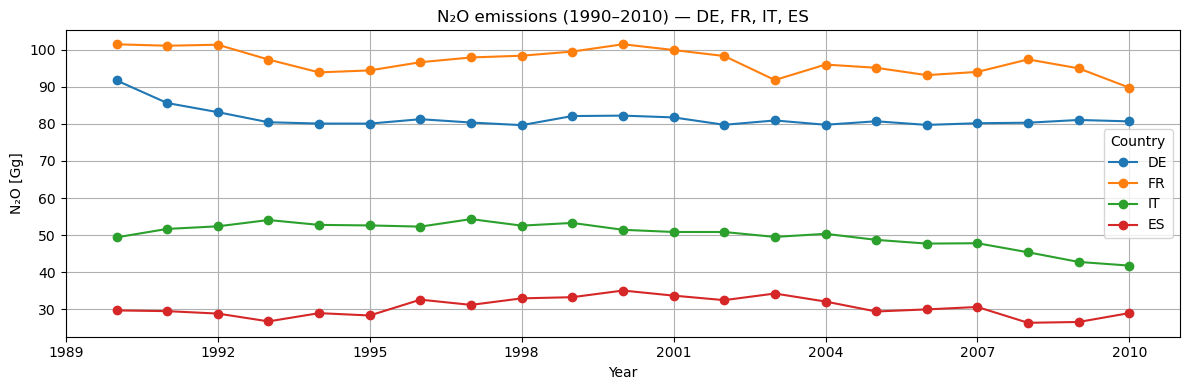

In [18]:
# parameters
pollutant = "N₂O"
countries = ["DE", "FR", "IT", "ES"]
year_min, year_max = 1990, 2010

# filter
eea_plot_data = eea_agr_agg[
    (eea_agr_agg["Pollutant_name"] == pollutant) &
    (eea_agr_agg["Country_code"].isin(countries)) &
    (eea_agr_agg["Year"].between(year_min, year_max))
]

# plot line per country
plt.figure(figsize=(12, 4))
for c in countries:
    sub = eea_plot_data[eea_plot_data["Country_code"] == c]
    plt.plot(sub["Year"], sub["emissions"], marker="o", label=c)

# make sure year axis only shows integer values
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True)) 
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

# labels, titles, legend, etc.
plt.xlabel("Year")
unit = eea_plot_data["Unit"].iloc[0]
plt.ylabel(f"{pollutant} [{unit}]")
title = (
    f"{pollutant} emissions "
    f"({year_min}–{year_max}) — "
    + ", ".join(countries)
)
plt.title(title)
plt.legend(title="Country")
plt.grid(True)
plt.tight_layout()
plt.show()

### Analysis

To conduct our analysis we first need to further prepare the two data sets. We rename columns and align the country naming.

In [78]:
diff_1 = set(eea_agr_eu27["Country"].unique()) - set(faostat_cls_eu_30_prod_t["Area"].unique())
diff_2 = set(faostat_cls_eu_30_prod_t["Area"].unique()) - set(eea_agr_eu27["Country"].unique())
display(diff_1, diff_2)

country_mapping = {
    "Netherlands (Kingdom of the)": "Netherlands"
}

production = faostat_cls_eu_30_prod_t.copy()
emission = eea_agr_eu27.copy()

production["Area"] = production["Area"].replace(country_mapping)

diff_3 = set(emission["Country"].unique()) - set(production["Area"].unique())
diff_4 = set(production["Area"].unique()) - set(emission["Country"].unique())
display(diff_3, diff_4)

production = production.rename(
    columns={
        "Area": "Country",
        "Value": "Production",
        "Unit": "Production Unit"
    }
)

emission = emission.drop(columns=["Sector_code"], errors="ignore")
emission = emission.rename(
    columns={
        "Pollutant_name": "Pollutant",
        "Unit": "Emission Unit",
        "emissions": "Emission",
        "Country_code": "Country Code",
        "Sector_name": "Sector"
    }
)

display(production)
display(emission)

{'Netherlands'}

{'Netherlands (Kingdom of the)'}

set()

set()

,Country,Item,Year,Production Unit,Production
135095,Austria,Apples,1990,t,337741.00
135096,Austria,Apples,1991,t,276848.00
135097,Austria,Apples,1992,t,268719.38
135098,Austria,Apples,1993,t,375222.36
135099,Austria,Apples,1994,t,334247.69
...,...,...,...,...,...
2652708,Sweden,Vegetables Primary,2019,t,310250.00
2652709,Sweden,Vegetables Primary,2020,t,342880.00
2652710,Sweden,Vegetables Primary,2021,t,353600.00
2652711,Sweden,Vegetables Primary,2022,t,335690.00


,Country Code,Country,Year,Pollutant,Emission Unit,Sector,Emission
2246,AT,Austria,2003,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,3.A.1 - Enteric Fermentation - Cattle,4278.32588
2247,AT,Austria,2004,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,3.A.1 - Enteric Fermentation - Cattle,4277.20015
2248,AT,Austria,2002,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,3.A.2 - Enteric Fermentation - Sheep,80.86629
2249,AT,Austria,2005,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,3.A.2 - Enteric Fermentation - Sheep,86.63159
2250,AT,Austria,2012,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,3.A.2 - Enteric Fermentation - Sheep,97.21482
...,...,...,...,...,...,...,...
628925,SE,Sweden,1990,N₂O,Gg,3.F.4 - Sugar cane,NaN
628926,SE,Sweden,1993,N₂O,Gg,3.F.4 - Sugar cane,NaN
628927,SE,Sweden,1996,N₂O,Gg,3.F.4 - Sugar cane,NaN
628928,SE,Sweden,2019,N₂O,Gg,3.F.4 - Sugar cane,NaN


We want to conduct an analysis on the livestock emissions and prodctions of countries. Therefore we select the sectors and items that represent this. We also select the aggregated pollutant "All greenhouse gases - (CO2 equivalent)" of the emission entries.

In [81]:
# EMISSION
livestock_sectors = [
    "3.A.1 - Enteric Fermentation - Cattle",
    "3.A.2 - Enteric Fermentation - Sheep",
    "3.A.3 - Enteric Fermentation - Swine",
    "3.A.4 - Enteric Fermentation - Other livestock",
    "3.B.1 - Manure Management - Cattle",
    "3.B.2 - Manure Management - Sheep",
    "3.B.3 - Manure Management - Swine",
    "3.B.4 - Manure Management - Other livestock",
    "3.B.5 - Manure Management - Indirect N2O Emissions"
]

# filter to livestock sources and total GHG (CO2e)
emission_animal = emission[
    (emission["Sector"].isin(livestock_sectors)) &
    (emission["Pollutant"] == "All greenhouse gases - (CO2 equivalent)")
].copy()

# aggregate emissions over all animal sector
emission_animal_agg = (
    emission_animal
    .groupby(
        ["Country Code", "Country", "Year", "Pollutant", "Emission Unit"],
        as_index=False
    )
    .agg({"Emission": "sum"})
)

display(emission_animal_agg)

# PRODUCTION
animal_items = [
    "Meat, Total",
    "Milk, Total",
    "Eggs Primary"
]

# filter to livestock items
production_animal = production[
    production["Item"].isin(animal_items)
].copy()

# aggregate products over all animal items
production_animal_agg = (
    production_animal
    .groupby(["Country", "Year"], as_index=False)
    .agg({"Production": "sum"})
)

display(production_animal_agg)

,Country Code,Country,Year,Pollutant,Emission Unit,Emission
0,AT,Austria,1990,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,6420.24859
1,AT,Austria,1991,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,6355.57246
2,AT,Austria,1992,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,6093.69539
3,AT,Austria,1993,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,6241.82134
4,AT,Austria,1994,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,6222.58654
...,...,...,...,...,...,...
913,SK,Slovakia,2019,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,1449.32195
914,SK,Slovakia,2020,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,1417.15683
915,SK,Slovakia,2021,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,1356.07894
916,SK,Slovakia,2022,All greenhouse gases - (CO2 equivalent),Gg CO2 equivalent,1348.24342


,Country,Year,Production
0,Austria,1990,4301918.00
1,Austria,1991,4261848.00
2,Austria,1992,4227677.00
3,Austria,1993,4206184.00
4,Austria,1994,4202890.00
...,...,...,...
877,Sweden,2019,3401080.00
878,Sweden,2020,3489300.00
879,Sweden,2021,3491380.00
880,Sweden,2022,3469039.24


#### Emissions vs. production (Decoupling)

We calculate the percentage change in livestock-related greenhouse gas emissions and animal-based agricultural production for each country.  
Afterwards, we compare the two changes and categorize countries according to the following rules (inspired by the Tapio framework):

- Countries are labelled as *green* if emissions decline faster than production during contraction.
- Countries are labelled as *green* if production grows while emissions decline or increase at a clearly slower rate.

With this aggregated information, we can identify countries that successfully decoupled livestock-related emissions from animal-based production volumes. Further research could investigate why these countries managed to decouple emissions from production.

In [89]:
# parameters
year_start = 2000
year_end = 2020
emission_col = f"Animal Emission % Change ({year_start}–{year_end})"
production_col = f"Animal Production % Change ({year_start}–{year_end})"
ratio_col = "ΔE% / ΔP%"

# helper function (% change)
def change_percentage(df, value_col):
    if year_start not in df["Year"].values or year_end not in df["Year"].values:
        return np.nan

    start = df.loc[df["Year"] == year_start, value_col].iloc[0]
    end   = df.loc[df["Year"] == year_end, value_col].iloc[0]

    if start == 0 or np.isnan(start) or np.isnan(end):
        return np.nan

    return (end / start - 1) * 100

# animal emission % change
emission_change = (
    emission_animal_agg
    .groupby("Country")
    .apply(lambda x: change_percentage(x, "Emission"))
    .reset_index(name=emission_col)
)

# animal production % change
production_change = (
    production_animal_agg
    .groupby("Country")
    .apply(lambda x: change_percentage(x, "Production"))
    .reset_index(name=production_col)
)

# merge into table
change_table = (
    emission_change
    .merge(production_change, on="Country", how="inner")
)

# classification logic
def classify_green(row):
    E = row[emission_col]
    P = row[production_col]

    if np.isnan(E) or np.isnan(P):
        return "Missing data"

    # 1) both decreased: emissions fell substantially faster than production (ratio > 1.2, inspired by Tapio elasticity)
    if E < 0 and P < 0:
        return (
            "Green contraction"
            if abs(E) / abs(P) > 1.20
            else "Not green"
        )

    # 2) emissions down, production up
    if E < 0 and P > 0:
        return "Green growth / decoupling"

    # 3) both up: emissions grew slower than production (elasticity < 0.8, inspired by Tapio elasticity)
    if E > 0 and P > 0:
        return (
            "Green growth / decoupling"
            if E / P < 0.8
            else "Not green"
        )

    return "Not green"


# add elasticity-style ratio column (only when E and P have same sign)
change_table[ratio_col] = np.where(
    np.sign(change_table[emission_col]) == np.sign(change_table[production_col]),
    change_table[emission_col] / change_table[production_col],
    np.nan
)

# add green category
change_table["Category"] = change_table.apply(classify_green, axis=1)

# sort by Category first, then by ratio
change_table = change_table.sort_values(
    by=["Category", ratio_col],
    ascending=[True, False]
)

display(change_table)

/var/folders/ld/jbbpbpx52r32jwrctm8l7rlc0000gn/T/ipykernel_7001/1236558886.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: change_percentage(x, "Emission"))
/var/folders/ld/jbbpbpx52r32jwrctm8l7rlc0000gn/T/ipykernel_7001/1236558886.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: change_percentage(x, "Production"))


,Country,Animal Emission % Change (2000–2020),Animal Production % Change (2000–2020),ΔE% / ΔP%,Category
22,Romania,-13.606018,-9.219270,1.475824,Green contraction
11,Greece,-7.944690,-6.294189,1.262226,Green contraction
5,Czechia,-16.257316,-12.949365,1.255453,Green contraction
24,Slovenia,-7.118760,-5.743765,1.239389,Green contraction
7,Estonia,22.714962,33.992009,0.668244,Green growth / decoupling
20,Poland,2.933671,32.139235,0.091280,Green growth / decoupling
13,Ireland,4.664735,57.042165,0.081777,Green growth / decoupling
17,Luxembourg,4.136843,65.649312,0.063014,Green growth / decoupling
0,Austria,-6.208009,16.264633,NaN,Green growth / decoupling
1,Belgium,-10.607587,12.267162,NaN,Green growth / decoupling
